#### Adni clinincal projections

In [3]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

from sklearn import svm
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
#Keeping the directory correctly 
import os
os.chdir('C:/Users/Rachneet Kaur/Desktop/CS598HDAProject/AlziemersData')


In [4]:
'''
Begin Function
'''
    #return null_in_cols,null_in_rows
def join_dataframes(item0,item1):
    a = pd.concat([(item0), (item1)], axis = 1 )
    a = a[a.iloc[:,2] == 0]
    return a

def numeric(data):
    for i in range(data.shape[1]):
        try:
            data.iloc[:,i] =  data.iloc[:,i].map( lambda x: pd.to_numeric(x, errors='ignore'))
        except:
            pass
    return data

# function used to normalize
def normalize(Train1,b):
    col_names = list(Train1.columns)
    '''
    if (Train1[col_names[i]] == Train1[col_names[i]][0] ).sum() = len(Train1):
        del Train1[col_names[i]]
    '''
    if (b == 'z'):
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - Train1[col_names[i]].mean(skipna = True)) / Train1[col_names[i]].std(skipna = True)
    else:
        for i in range(Train1.shape[1]):
            Train1[col_names[i]] = (Train1[col_names[i]] - min(Train1[col_names[i]]) )/ ( max(Train1[col_names[i]] ) - min(Train1[col_names[i]]) )
    return Train1

'''
END Function
'''

'\nEND Function\n'

#### Imputations

In [5]:
# Moca
cols = {}
cols['moca'] = ['RID','VISCODE2', 'TRAILS', 'CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN','LION', 'RHINO', 'CAMEL', 'IMMT1W1', 'IMMT1W2', 'IMMT1W3', 'IMMT1W4',
       'IMMT1W5', 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5','DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3',
       'SERIAL4', 'SERIAL5', 'REPEAT1', 'REPEAT2', 'FFLUENCY', 'ABSTRAN','ABSMEAS', 'DELW1', 'DELW2', 'DELW3', 'DELW4', 'DELW5', 'DATE', 'MONTH',
       'YEAR', 'DAY', 'PLACE', 'CITY']
cols['moca_visuospatial'] = [ 'TRAILS', 'CUBE', 'CLOCKCON', 'CLOCKNO', 'CLOCKHAN']
cols['moca_naming'] = [ 'LION', 'RHINO', 'CAMEL']
cols['moca_orientation'] =['DATE', 'MONTH', 'YEAR', 'DAY', 'PLACE', 'CITY']
cols['moca_delayed_recall'] = [ 'IMMT1W5', 'IMMT2W1', 'IMMT2W2', 'IMMT2W3', 'IMMT2W4', 'IMMT2W5']
cols['moca_attention'] = [ 'DIGFOR', 'DIGBACK', 'LETTERS', 'SERIAL1', 'SERIAL2', 'SERIAL3','SERIAL4', 'SERIAL5']
cols['moca_language'] = ['REPEAT1', 'REPEAT2', 'FFLUENCY']
cols['moca_abstraction'] = ['ABSTRAN','ABSMEAS']
moca = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MOCA.csv', usecols=cols['moca'], index_col = ['RID', 'VISCODE2'])
moca['visuospatial'] = moca[cols['moca_visuospatial']].sum(axis=1)
moca['naming'] = moca[cols['moca_naming']].sum(axis=1)
moca['orientation'] = moca[cols['moca_orientation']].sum(axis = 1)
moca['delayed_recall'] = moca[cols['moca_delayed_recall']].sum(axis=1)
moca['attention'] = moca[cols['moca_attention']].sum(axis=1)
moca['abstraction'] = moca[cols['moca_abstraction']].sum(axis=1)
moca['language'] = moca[cols['moca_language']].sum(axis=1)
moca = moca[['visuospatial', 'naming', 'attention', 'language', 'delayed_recall', 'orientation', 'abstraction']] # drop extra
moca1 = moca.copy(deep = True) 
moca = moca[~moca.index.duplicated()].reset_index()
moca = moca[moca.VISCODE2.isin(['sc','bl','m06','m12'])].set_index(['RID','VISCODE2'])
moca = moca.unstack()
feature = list(moca.columns.levels[0])
for i in range(len(feature)):
        moca[feature[i]]['m12'][(moca[feature[i]]['m12']).isnull()] = moca[feature[i]]['bl'][(moca[feature[i]]['m12']).isnull()]
        moca[feature[i]]['m06'][(moca[feature[i]]['m06']).isnull()] = moca[feature[i]]['bl'][(moca[feature[i]]['m06']).isnull()]
        
print(moca.isnull().sum().sum())

0


In [6]:
# modhach
cols['modhach'] = ['RID','VISCODE2', 'HMONSET', 'HMSTEPWS', 'HMSOMATC', 'HMEMOTIO', 'HMHYPERT', 'HMSTROKE', 'HMNEURSM', 'HMNEURSG', 'HMSCORE']
modhach = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MODHACH.csv', usecols=cols['modhach'], index_col = ['RID', 'VISCODE2'])
modhach1 = modhach.copy(deep = True) 
modhach = modhach[~modhach.index.duplicated()].reset_index()
modhach = modhach[modhach.VISCODE2.isin(['sc','bl','m06','m12'])].set_index(['RID','VISCODE2'])
modhach = modhach.unstack()
modhach = modhach[ (modhach.isnull().sum(axis = 1) < 1) ]
print(modhach.isnull().sum().sum())

0


In [7]:
# Neurobat
cols['neurobat'] = ['RID', 'VISCODE2', 'CLOCKSCOR', 'COPYSCOR', 'LMSTORY', 'LIMMTOTAL', 'LIMMEND',
       'AVTOT1', 'AVERR1', 'AVTOT2', 'AVERR2', 'AVTOT3', 'AVERR3', 'AVTOT4',
       'AVERR4', 'AVTOT5', 'AVERR5', 'AVTOT6', 'AVERR6', 'AVTOTB', 'AVERRB',
       'AVENDED', 'DSPANFOR', 'DSPANFLTH', 'DSPANBAC', 'DSPANBLTH',
       'CATANIMSC', 'CATANPERS', 'CATANINTR', 'CATVEGESC', 'CATVGPERS',
       'CATVGINTR', 'TRAASCOR', 'TRAAERRCOM', 'TRAAERROM', 'TRABSCOR',
       'TRABERRCOM', 'TRABERROM', 'DIGITSCOR', 'LDELBEGIN', 'LDELTOTAL',
       'LDELCUE','BNTTOTAL', 'AVDELBEGAN', 'AVDEL30MIN', 'AVDELERR1',
       'AVDELTOT', 'AVDELERR2', 'ANARTND', 'ANARTERR']
neurobat = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NEUROBAT.csv', usecols=cols['neurobat'], index_col = ['RID', 'VISCODE2'])
neurobat1 = neurobat.copy(deep = True) 
neurobat = neurobat.replace({-4: np.NAN})
neurobat = neurobat[~neurobat.index.duplicated()].reset_index()
neurobat = neurobat[neurobat.VISCODE2.isin(['sc','bl','m06','m12'])].set_index(['RID','VISCODE2'])
neurobat = neurobat[ (neurobat.isnull().sum(axis = 1) < 25) ]
neurobat = neurobat.T[ (neurobat.T.isnull().sum(axis = 1) < 2000) ].T 
neurobat = neurobat.interpolate(method='linear', axis=1, limit=10, limit_direction='both')
neurobat = neurobat.unstack()
feature = list(neurobat.columns.levels[0])
for i in range(len(feature)):
        neurobat[feature[i]]['m06'][(neurobat[feature[i]]['m06']).isnull()] = neurobat[feature[i]]['bl'][(neurobat[feature[i]]['m06']).isnull()]
        neurobat[feature[i]]['m12'][(neurobat[feature[i]]['m12']).isnull()] = neurobat[feature[i]]['m06'][(neurobat[feature[i]]['m12']).isnull()]

print(neurobat.isnull().sum().sum())

0


In [8]:
#NPI
cols['npi'] = ['RID', 'VISCODE2','NPIATOT', 'NPIBTOT', 'NPICTOT',  'NPIDTOT', \
    'NPIETOT', 'NPIFTOT', 'NPIGTOT', 'NPIHTOT', 'NPIITOT', 'NPIJTOT','NPIKTOT', 'NPILTOT']
npi = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NPI.csv', usecols=cols['npi'], index_col = ['RID', 'VISCODE2'])
npi1 = npi.copy(deep = True) 
npi = npi[~npi.index.duplicated()].reset_index()
npi = npi[npi.VISCODE2.isin(['sc','bl','m06','m12'])].set_index(['RID','VISCODE2'])
npi = npi[ (npi.isnull().sum(axis = 1) < 8) ]
npi = npi.unstack()
feature = list(npi.columns.levels[0])
for i in range(len(feature)):
        npi[feature[i]]['m12'][(npi[feature[i]]['m12']).isnull()] = npi[feature[i]]['bl'][(npi[feature[i]]['m12']).isnull()]
        npi[feature[i]]['bl'][(npi[feature[i]]['bl']).isnull()] = npi[feature[i]]['m12'][(npi[feature[i]]['bl']).isnull()]
print(npi.isnull().sum().sum())

0


In [9]:
#NPIQ
cols['npiq'] = ['RID', 'VISCODE2', 'NPIA', 'NPIASEV', 'NPIB','NPIBSEV', 'NPIC', 'NPICSEV', 'NPID', 
'NPIDSEV', 'NPIE', 'NPIESEV','NPIF', 'NPIFSEV', 'NPIG', 'NPIGSEV', 'NPIH', 'NPIHSEV', 'NPII', 
'NPIISEV', 'NPIJ', 'NPIJSEV', 'NPIK', 'NPIKSEV', 'NPIL', 'NPILSEV']
npiq = pd.read_csv('ADNI\\Raw_Data\\Assessment\\NPIQ.csv', usecols=cols['npiq'], index_col = ['RID', 'VISCODE2'])
npiq1 = npiq.copy(deep = True) 

#Replcing all -4 to 0 
npiq = npiq.replace({-4: 0})
npiq = npiq[~npiq.index.duplicated()].reset_index()
npiq = npiq[npiq.VISCODE2.isin(['sc','bl','m06','m12'])].set_index(['RID','VISCODE2'])

#Multiplying whether of not with the severity ratings
npiq['NPIA_total'] = npiq['NPIA']*npiq['NPIASEV']
npiq['NPIB_total'] = npiq['NPIB']*npiq['NPIBSEV']
npiq['NPIC_total'] = npiq['NPIC']*npiq['NPICSEV']
npiq['NPID_total'] = npiq['NPID']*npiq['NPIDSEV']
npiq['NPIE_total'] = npiq['NPIE']*npiq['NPIESEV']
npiq['NPIF_total'] = npiq['NPIF']*npiq['NPIFSEV']
npiq['NPIG_total'] = npiq['NPIG']*npiq['NPIGSEV']
npiq['NPIH_total'] = npiq['NPIH']*npiq['NPIHSEV']
npiq['NPII_total'] = npiq['NPII']*npiq['NPIISEV']
npiq['NPIJ_total'] = npiq['NPIJ']*npiq['NPIJSEV']
npiq['NPIK_total'] = npiq['NPIK']*npiq['NPIKSEV']
npiq['NPIL_total'] = npiq['NPIL']*npiq['NPILSEV']

#Taking the multiplied columns only 
npiq = npiq[['NPIA_total', 'NPIB_total', 'NPIC_total', 'NPID_total', 'NPIE_total', 'NPIF_total', 'NPIG_total',\
             'NPIH_total', 'NPII_total', 'NPIJ_total', 'NPIK_total', 'NPIL_total']] # drop extra
npiq = npiq[ (npiq.isnull().sum(axis = 1) < 6) ]
npiq = npiq.unstack()
feature = list(npiq.columns.levels[0])
for i in range(len(feature)):
        npiq[feature[i]]['m06'][(npiq[feature[i]]['m06']).isnull()] = npiq[feature[i]]['bl'][(npiq[feature[i]]['m06']).isnull()]
        npiq[feature[i]]['m12'][(npiq[feature[i]]['m12']).isnull()] = npiq[feature[i]]['m06'][(npiq[feature[i]]['m12']).isnull()]
npiq = npiq.interpolate(method='linear', axis=1, limit=10, limit_direction='both')

print(npiq.isnull().sum().sum())

0


In [10]:
#MMSE
cols['mmse'] = ['RID', 'VISCODE2','MMSCORE']
mmse = pd.read_csv('ADNI\\Raw_Data\\Assessment\\MMSE.csv', usecols=cols['mmse'], index_col = ['RID', 'VISCODE2'])
mmse1 = mmse.copy(deep = True) 
mmse = mmse[~mmse.index.duplicated()].reset_index()
mmse = mmse[mmse.VISCODE2.isin(['sc','bl','m06','m12'])].set_index(['RID','VISCODE2'])
mmse = mmse[~mmse.index.duplicated()]
mmse = mmse.unstack()
feature = list(mmse.columns.levels[0])
for i in range(len(feature)):
        mmse[feature[i]]['m06'][(mmse[feature[i]]['m06']).isnull()] = mmse[feature[i]]['sc'][(mmse[feature[i]]['m06']).isnull()]
        mmse[feature[i]]['m12'][(mmse[feature[i]]['m12']).isnull()] = mmse[feature[i]]['m06'][(mmse[feature[i]]['m12']).isnull()]
mmse = mmse[ (mmse.isnull().sum(axis = 1) < 2) ]

print(mmse.isnull().sum().sum())

0


In [11]:
#FAQ
cols['faq'] = ['RID', 'VISCODE2', 'FAQTOTAL']
faq = pd.read_csv('ADNI\\Raw_Data\\Assessment\\FAQ.csv', usecols=cols['faq'], index_col = ['RID', 'VISCODE2'])
faq1 = faq.copy(deep = True) 
faq = faq[~faq.index.duplicated()].reset_index()
faq = faq[faq.VISCODE2.isin(['sc','bl','m06','m12'])].set_index(['RID','VISCODE2'])
faq = faq[~faq.index.duplicated()]
faq = faq.unstack()
feature = list(faq.columns.levels[0])
for i in range(len(feature)):
        faq[feature[i]]['m06'][(faq[feature[i]]['m06']).isnull()] = faq[feature[i]]['bl'][(faq[feature[i]]['m06']).isnull()]
        faq[feature[i]]['m12'][(faq[feature[i]]['m12']).isnull()] = faq[feature[i]]['m06'][(faq[feature[i]]['m12']).isnull()]
faq = faq[ (faq.isnull().sum(axis = 1) < 2) ]
faq = faq.interpolate(method='linear', axis=1, limit=10, limit_direction='both')

print(faq.isnull().sum().sum())

0


In [12]:
#MEDICAL HISTORY
cols['medhist'] = ['RID','VISCODE2','MHPSYCH', 'MH2NEURL', 'MH3HEAD','MH4CARD', 'MH5RESP', 'MH6HEPAT', 
'MH7DERM', 'MH8MUSCL', 'MH9ENDO','MH10GAST', 'MH11HEMA', 'MH12RENA', 'MH13ALLE', 'MH14ALCH',
'MH14AALCH','MH14BALCH', 'MH14CALCH', 'MH15DRUG', 'MH15ADRUG', 'MH15BDRUG','MH16SMOK', 'MH16ASMOK', 
'MH16BSMOK', 'MH16CSMOK', 'MH17MALI','MH18SURG', 'MH19OTHR']
medhist = pd.read_csv('ADNI\\Raw_Data\\medical\\MEDHIST.csv', usecols=cols['medhist'], index_col = ['RID', 'VISCODE2'])
medhist1 = medhist.copy(deep = True) 
medhist = medhist[~medhist.index.duplicated()].reset_index()
medhist = medhist[medhist.VISCODE2.isin(['sc','bl','m06','m12'])].set_index(['RID','VISCODE2'])
medhist = medhist[~medhist.index.duplicated()]
medhist = medhist.unstack()
medhist = medhist.T[ (medhist.T.isnull().sum(axis = 1) < 1500) ].T   
feature = list(medhist.columns.levels[0])
for i in range(len(feature)):
    try:
        medhist[feature[i]]['sc'][(medhist[feature[i]]['sc']).isnull()] = -4
    except:
        pass

print(medhist.isnull().sum().sum())

0


In [13]:
#PHYSICAL
#Keep only one feature PXMUSCUL
cols['physical'] = ['RID','VISCODE2','PXMUSCUL']
physical = pd.read_csv('ADNI\\Raw_Data\\medical\\PHYSICAL.csv', usecols=cols['physical'], index_col = ['RID','VISCODE2'])
physical1 = physical.copy(deep = True) 
physical = physical[~physical.index.duplicated()].reset_index()
physical = physical[physical.VISCODE2.isin(['sc','bl','m06','m12'])].set_index(['RID','VISCODE2'])
physical = physical[~physical.index.duplicated()]
physical = physical.unstack()
physical = physical[ (physical.isnull().sum(axis = 1) ==0) ]
print(physical.isnull().sum().sum())

0


In [14]:
#RECBLLOG
cols['recbllog'] = ['RID','VISCODE2', 'BSXSYMNO', 'BSXSEVER', 'BSXCHRON','BSXCONTD']
recbllog = pd.read_csv('ADNI\\Raw_Data\\medical\\RECBLLOG.csv', usecols=cols['recbllog'], index_col = ['RID', 'VISCODE2'])
recbllog1 = recbllog.copy(deep = True) 
recbllog = recbllog[~recbllog.index.duplicated()].reset_index()
recbllog = recbllog[recbllog.VISCODE2.isin(['sc','bl'])].set_index(['RID','VISCODE2'])
recbllog = recbllog[~recbllog.index.duplicated()]
recbllog = recbllog[ (recbllog.isnull().sum(axis = 1) < 2) ]
#Unstacking 
recbllog = recbllog.unstack()
feature = list(recbllog.columns.levels[0])
for i in range(len(feature)):
        recbllog[feature[i]]['bl'][(recbllog[feature[i]]['bl']).isnull()] = recbllog[feature[i]]['sc'][(recbllog[feature[i]]['bl']).isnull()]
recbllog = recbllog.T[ (recbllog.T.isnull().sum(axis = 1) < 300) ].T 
print(recbllog.isnull().sum().sum())

0


In [15]:
#NEUROEXM
cols['neuroexm'] = ['RID','VISCODE2', 'NXVISUAL',  'NXAUDITO', 'NXTREMOR', 'NXCONSCI', 'NXNERVE', 'NXMOTOR', 'NXFINGER', 'NXHEEL', 'NXSENSOR', 'NXTENDON', 'NXPLANTA', 'NXGAIT', 'NXOTHER']
neuroexm = pd.read_csv('ADNI\\Raw_Data\\medical\\NEUROEXM.csv', usecols=cols['neuroexm'], index_col=['RID', 'VISCODE2'])
neuroexm1 = neuroexm.copy(deep = True) 
del neuroexm['NXOTHER']
neuroexm = neuroexm[~neuroexm.index.duplicated()].reset_index()
neuroexm = neuroexm[neuroexm.VISCODE2.isin(['sc','bl','m06','m12'])].set_index(['RID','VISCODE2'])
neuroexm = neuroexm[~neuroexm.index.duplicated()]
neuroexm = neuroexm[ (neuroexm.isnull().sum(axis = 1) < 8) ]
neuroexm = neuroexm.unstack()
neuroexm = neuroexm.interpolate(method='linear', axis=1, limit=10, limit_direction='both')
print(neuroexm.isnull().sum().sum())

0


In [16]:
cols['UWNPSYCHSUM_10_27_17'] = ['RID', 'VISCODE2', 'ADNI_MEM', 'ADNI_EF']
uwn = pd.DataFrame(pd.read_csv("ADNI\\Raw_Data\\Assessment\\UWNPSYCHSUM_10_27_17.csv",index_col= ['RID','VISCODE2'], usecols=cols['UWNPSYCHSUM_10_27_17']))
uwn1 = uwn.copy(deep = True) 
uwn = uwn[~uwn.index.duplicated()].reset_index()
uwn = uwn[uwn.VISCODE2.isin(['sc','bl','m06','m12'])].set_index(['RID','VISCODE2'])
uwn = uwn[~uwn.index.duplicated()].unstack()
feature = list(uwn.columns.levels[0])
for i in range(len(feature)):
        uwn[feature[i]]['m06'][(uwn[feature[i]]['m06']).isnull()] = uwn[feature[i]]['bl'][(uwn[feature[i]]['m06']).isnull()]
        uwn[feature[i]]['m12'][(uwn[feature[i]]['m12']).isnull()] = uwn[feature[i]]['bl'][(uwn[feature[i]]['m12']).isnull()]
print(neuroexm.isnull().sum().sum())

0


In [17]:
#Item

item = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ITEM.csv")
total_cols = item.columns
item_del = ['ADAS_ExamDate','ANART_ExamDate','AVLT_ExamDate','AVLT_Delay_ExamDate','BosNam_ExamDate'\
            ,'CatFlu_ExamDate','CDT_ExamDate','DSBac_ExamDate','DSFor_ExamDate','LogMemIA_ExamDate'\
            ,'MMSE_ExamDate','TMT_ExamDate','WAISR_ExamDate','LogMemIIA_ExamDate', 'ADAS_Q1_TimeEnded',\
            'ADAS_Q4_TimeBegan','AVLT_DelayTime']
cols['item'] = set(total_cols) - set(item_del) 
item = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ITEM.csv", usecols=cols['item'])
item_new = item.copy(deep = True)
item_new['VISCODE2'] = item_new['VISCODE']
item_0 = item.iloc[:,0:2]
item_1 = item.iloc[:,2:3]
item_1a = pd.concat([(item_1), (item.iloc[:,2:93])], axis = 1 )
item_1b = pd.concat([(item_1), (item.iloc[:,93:102])], axis = 1 )
item_1c = pd.concat([(item_1), (item.iloc[:,102:132])], axis = 1 )
item_1d = pd.concat([(item_1), (item.iloc[:,132:149])], axis = 1 )
item_1e = pd.concat([(item_1), (item.iloc[:,149:154])], axis = 1 )
item_1f = pd.concat([(item_1), (item.iloc[:,154:162])], axis = 1 )
item_1g = pd.concat([(item_1), (item.iloc[:,162:306])], axis = 1 )
item_1h = pd.concat([(item_1), (item.iloc[:,306:310])], axis = 1 )
item_2 = item.iloc[:,313:364]
item_3 = item.iloc[:,364:576]
item_4 = pd.concat([(item.iloc[:,364:365]), (item.iloc[:,576:583])], axis = 1 )
item_5 = item.iloc[:,583:615]
item_6 = item.iloc[:,617:648]
item_7 = item.iloc[:,648:656]
item_8 = item.iloc[:,656:667]
item_9 = item.iloc[:,667:681]
item_10 = item.iloc[:,681:695]
item_11 = item.iloc[:,695:702]
item_12 = item.iloc[:,702:739]
item_13 = item.iloc[:,739:746]
item_14 = item.iloc[:,746:748]

# item 1a
item1a = join_dataframes(item_0,item_1a) 
del item1a['ADAS_QuestionnaireNotAttempted'] 
item1a = item1a[item1a['VISCODE'].isin(['bl', 'm06'])]  
item1a = item1a.T[ (item1a.T.isnull().sum(axis = 1) < 1200) ].T
item1a = numeric(item1a)
#item1a =item1a.fillna(0)
item1a = item1a.set_index(['RID','VISCODE'])
item1a = item1a[~item1a.index.duplicated()].unstack()
item1a = numeric(item1a)
#len(item1a)
item1a = item1a.T[ (item1a.T.isnull().sum(axis = 1) < 600) ].T
item1a = item1a[ (item1a.isnull().sum(axis = 1) < 7) ]
#item1a.iloc[:,:] =item1a.iloc[:,:].interpolate(method='linear', axis=1, limit=20, limit_direction='both')
#len(item1a)
#item1a['ADAS_Q1_Total'] = item1a.sum(axis=1)
#item1a = item1a['ADAS_Q1_Total'] 

# item 1b
item1b = join_dataframes(item_0,item_1b) 
del item1b['ADAS_QuestionnaireNotAttempted'] 
item1b = item1b[item1b['VISCODE'].isin(['bl', 'm06']) ]  
item1b = item1b[ (item1b.isnull().sum(axis = 1) < 7) ]
item1b.iloc[:,2:] =item1b.iloc[:,2:].interpolate(method='linear', axis=1, limit=10, limit_direction='both')
item1b = item1b.set_index(['RID','VISCODE'])
item1b = item1b[~item1b.index.duplicated()].unstack()
item1b = numeric(item1b)
#len(item1b)
item1b = item1b[ (item1b.isnull().sum(axis = 1) < 7) ]
#item1a['ADAS_Q1_Total'] = item1a.sum(axis=1)
#item1a = item1a['ADAS_Q1_Total'] 

# item 1c
item1c = join_dataframes(item_0,item_1c) 
del item1c['ADAS_QuestionnaireNotAttempted'] 
item1c = item1c[item1c['VISCODE'].isin(['bl', 'm06']) ]  
item1c = item1c.T[ (item1c.T.isnull().sum(axis = 1) < 1200) ].T
item1c = numeric(item1c)
item1c = item1c.set_index(['RID','VISCODE'])
item1c = item1c[~item1c.index.duplicated()].unstack()
item1c = item1c.T[ (item1c.T.isnull().sum(axis = 1) < 600) ].T
item1c = item1c[ (item1c.isnull().sum(axis = 1) < 7) ]
#len(item1c)
#item1a['ADAS_Q1_Total'] = item1a.sum(axis=1)
#item1a = item1a['ADAS_Q1_Total'] 


# item 1d
item1d = join_dataframes(item_0,item_1d) 
del item1d['ADAS_QuestionnaireNotAttempted'] 
item1d = item1d[item1d['VISCODE'].isin(['bl', 'm06']) ]  
item1d = item1d[ (item1d.isnull().sum(axis = 1) < 14) ]
item1d.iloc[:,2:] =item1d.iloc[:,2:].interpolate(method='linear', axis=1, limit=10, limit_direction='both')
item1d = numeric(item1d)
item1d = item1d.set_index(['RID','VISCODE'])
item1d = item1d[~item1d.index.duplicated()].unstack()
item1d = item1d[ (item1d.isnull().sum(axis = 1) < 14) ]
#len(item1d)


# item 1d
item1d = join_dataframes(item_0,item_1d) 
del item1d['ADAS_QuestionnaireNotAttempted'] 
item1d = item1d[item1d['VISCODE'].isin(['bl', 'm06']) ]  
item1d = item1d[ (item1d.isnull().sum(axis = 1) < 14) ]
item1d.iloc[:,2:] =item1d.iloc[:,2:].interpolate(method='linear', axis=1, limit=10, limit_direction='both')
item1d = numeric(item1d)
item1d = item1d.set_index(['RID','VISCODE'])
item1d = item1d[~item1d.index.duplicated()].unstack()
item1d = item1d[ (item1d.isnull().sum(axis = 1) < 14) ]
#len(item1d)

# item 1e
item1e = join_dataframes(item_0,item_1e) 
del item1e['ADAS_QuestionnaireNotAttempted'] 
item1e = item1e[item1e['VISCODE'].isin(['bl', 'm06']) ]  
item1e = item1e.set_index(['RID','VISCODE'])
item1e = item1e[~item1e.index.duplicated()].unstack()
item1e = item1e[ (item1e.isnull().sum(axis = 1) < 8) ]
item1e.iloc[:,:] =item1e.iloc[:,:].interpolate(method='linear', axis=1, limit=10, limit_direction='both')
#len(item1e)


# item 1f
item1f = join_dataframes(item_0,item_1f) 
del item1f['ADAS_QuestionnaireNotAttempted'] 
item1f = item1f[item1f['VISCODE'].isin(['bl', 'm06']) ]  
item1f = item1f.set_index(['RID','VISCODE'])
item1f = item1f[~item1f.index.duplicated()].unstack()
item1f = item1f[ (item1f.isnull().sum(axis = 1) < 12) ]
item1f.iloc[:,:] =item1f.iloc[:,:].interpolate(method='linear', axis=1, limit=10, limit_direction='both')
#len(item1f)


# item 1g
item1g = join_dataframes(item_0,item_1g) 
del item1g['ADAS_QuestionnaireNotAttempted'] 
item1g = item1g[item1g['VISCODE'].isin(['bl', 'm06']) ]  
item1g = item1g.set_index(['RID','VISCODE'])
item1g = item1g[~item1g.index.duplicated()].unstack()
item1g = item1g.T[ (item1g.T.isnull().sum(axis = 1) < 600) ].T
item1g.iloc[:,:] =item1g.iloc[:,:].interpolate(method='linear', axis=0, limit=10, limit_direction='both')
#len(item1g)


# item 1h
item1h = join_dataframes(item_0,item_1h) 
del item1h['ADAS_QuestionnaireNotAttempted'] 
item1h = item1h[item1h['VISCODE'].isin(['bl', 'm06']) ]  
item1h = numeric(item1h)
item1h = item1h.set_index(['RID','VISCODE'])
item1h = item1h[~item1h.index.duplicated()].unstack()
item1h = item1h[ (item1h.isnull().sum(axis = 1) < 6) ]
item1h.iloc[:,:] =item1h.iloc[:,:].interpolate(method='linear', axis=1, limit=10, limit_direction='both')
#len(item1h)


# item 2
item2 = join_dataframes(item_0,item_2) 
del item2['ANART_QuestionnaireNotAttempted'] 
item2 = item2[item2['VISCODE'].isin(['bl', 'm06','m12','sc']) ] 
item2 = item2.set_index(['RID','VISCODE'])
item2 = item2[~item2.index.duplicated()].unstack()
item2 = item2[ (item2.isnull().sum(axis = 1) < 20) ]
item2.iloc[:,:] =item2.iloc[:,:].interpolate(method='linear', axis=1, limit=20, limit_direction='both')
item2 = numeric(item2)
#len(item2)

item2.isnull().sum(axis = 1).value_counts().sort_values()
item2.isnull().sum(axis = 1).value_counts().sort_index()


# item 3
item3 = join_dataframes(item_0,item_3) 
del item3['AVLT_QuestionnaireNotAttempted'] 
del item3['AVLT_StartTime'] 
item3 = item3[item3['VISCODE'].isin(['bl', 'm06']) ]  
item3 = numeric(item3)
item3 = item3.set_index(['RID','VISCODE'])
item3 = item3[~item3.index.duplicated()].unstack()
item3 = item3[ (item3.isnull().sum(axis = 1) < 280) ]
item3 = item3.T[ (item3.T.isnull().sum(axis = 1) < 600) ].T
#len(item3)


# item 4
item4 = join_dataframes(item_0,item_4) 
del item4['AVLT_QuestionnaireNotAttempted'] 
item4 = item4[item4['VISCODE'].isin(['bl', 'm06']) ]  
item4 = item4.set_index(['RID','VISCODE'])
item4 = item4[~item4.index.duplicated()].unstack()
item4 = item4[ (item4.isnull().sum(axis = 1) < 5) ]
#len(item4)

# item 5
item5 = join_dataframes(item_0,item_5) 
del item5['AVLT_Delay_QuestionnaireNotAttempted'] 
item5 = item5[item5['VISCODE'].isin(['bl', 'm06']) ]
item5 = item5.set_index(['RID','VISCODE'])
item5 = item5[~item5.index.duplicated()].unstack()
item5 = item5.T[ (item5.T.isnull().sum(axis = 1) < 600) ].T
item5 = item5[ (item5.isnull().sum(axis = 1) < 12) ]
#len(item5)

# item 6
item6 = join_dataframes(item_0,item_6) 
del item6['BosNam_QuestionnaireNotAttempted'] 
item6 = item6[item6['VISCODE'].isin(['bl', 'm06']) ]  
item6 = item6[ (item6.isnull().sum(axis = 1) < 14) ]
item6 = item6.set_index(['RID','VISCODE'])
item6 = item6[~item6.index.duplicated()].unstack()
item6 = item6[ (item6.isnull().sum(axis = 1) < 25) ]
#len(item6)


# item 7
item7 = join_dataframes(item_0,item_7) 
del item7['CatFlu_QuestionnaireNotAttempted'] 
item7 = item7[item7['VISCODE'].isin(['bl', 'm06']) ]
item7 = item7.set_index(['RID','VISCODE'])
item7 = item7[~item7.index.duplicated()].unstack()
item7 = item7[ (item7.isnull().sum(axis = 1) < 6) ]
#len(item7)


# item 8
item8 = join_dataframes(item_0,item_8) 
del item8['CDT_QuestionnaireNotAttempted'] 
item8 = item8[item8['VISCODE'].isin(['bl', 'm06']) ]  
item8 = item8[ (item8.isnull().sum(axis = 1) < 8) ]
item8.iloc[:,2:] =item8.iloc[:,2:].interpolate(method='linear', axis=1, limit=10, limit_direction='both')
item8 = item8.set_index(['RID','VISCODE'])
item8 = item8[~item8.index.duplicated()].unstack()
item8.iloc[:,:] =item8.iloc[:,:].interpolate(method='linear', axis=1, limit=10, limit_direction='both')
#len(item8)


# item 9
item9 = join_dataframes(item_0,item_9) 
del item9['DSBac_QuestionnaireNotAttempted'] 
item9 = item9[item9['VISCODE'].isin(['bl', 'm06']) ]  
item9 = item9.set_index(['RID','VISCODE'])
item9 = item9[~item9.index.duplicated()].unstack()
item9 = item9[ (item9.isnull().sum(axis = 1) < 10) ]
#len(item9)


# item 10
item10 = join_dataframes(item_0,item_10) 
del item10['DSFor_QuestionnaireNotAttempted'] 
item10 = item10[item10['VISCODE'].isin(['bl', 'm06']) ]  
item10 = item10.set_index(['RID','VISCODE'])
item10 = item10[~item10.index.duplicated()].unstack()
item10 = item10[ (item10.isnull().sum(axis = 1) < 10) ]
#len(item10)

'''
# item 11 neglecting because too less observation

neglecting

item11 = join_dataframes(item_0,item_11) 
del item11['LogMemIA_QuestionnaireNotAttempted'] 
item11 = item11[item11['VISCODE'].isin(['bl', 'm06']) ]  
item11 = item11.set_index(['RID','VISCODE'])
item11 = item11[~item11.index.duplicated()].unstack()
'''

# item 12
item12 = join_dataframes(item_0,item_12) 
del item12['MMSE_QuestionnaireNotAttempted'] 
del item12['MMSE_Q14value'] 
del item12['MMSE_Q15value'] 
del item12['MMSE_Q16value'] 
del item12['MMSE_Q17value'] 
del item12['MMSE_Q18value'] 
item12 = item12[item12['VISCODE'].isin(['bl', 'm06']) ]  
item12 = item12[ (item12.isnull().sum(axis = 1) < 25) ]
item12 = item12.set_index(['RID','VISCODE'])
item12 = item12[~item12.index.duplicated()].unstack()
item12.iloc[:,:] =item12.iloc[:,:].interpolate(method='linear', axis=1, limit=20, limit_direction='both')
#len(item12)


# item 13
item13 = join_dataframes(item_0,item_13) 
del item13['TMT_QuestionnaireNotAttempted'] 
item13 = item13[item13['VISCODE'].isin(['bl', 'm06']) ]  
item13 = item13.set_index(['RID','VISCODE'])
item13 = item13[~item13.index.duplicated()].unstack()
item13 = item13[ (item13.isnull().sum(axis = 1) < 5) ]
#len(item13)

# item 14
item14 = join_dataframes(item_0,item_14) 
del item14['WAISR_QuestionnaireNotAttempted'] 
item14 = item14[item14['VISCODE'].isin(['bl', 'm06']) ]  
item14 = item14.set_index(['RID','VISCODE'])
item14 = item14[~item14.index.duplicated()].unstack()
item14 = item14[ (item14.isnull().sum(axis = 1) < 1) ]
#len(item14)
item_0 = item.iloc[:,0:2]
item_1 = item.iloc[:,2:3]
item_1a = pd.concat([(item_1), (item.iloc[:,2:93])], axis = 1 )
item_1b = pd.concat([(item_1), (item.iloc[:,93:102])], axis = 1 )
item_1c = pd.concat([(item_1), (item.iloc[:,102:132])], axis = 1 )
item_1d = pd.concat([(item_1), (item.iloc[:,132:149])], axis = 1 )
item_1e = pd.concat([(item_1), (item.iloc[:,149:154])], axis = 1 )
item_1f = pd.concat([(item_1), (item.iloc[:,154:162])], axis = 1 )
item_1g = pd.concat([(item_1), (item.iloc[:,162:306])], axis = 1 )
item_1h = pd.concat([(item_1), (item.iloc[:,306:310])], axis = 1 )
item_2 = item.iloc[:,313:364]
item_3 = item.iloc[:,364:576]
item_4 = pd.concat([(item.iloc[:,364:365]), (item.iloc[:,576:583])], axis = 1 )
item_5 = item.iloc[:,583:615]
item_6 = item.iloc[:,617:648]
item_7 = item.iloc[:,648:656]
item_8 = item.iloc[:,656:667]
item_9 = item.iloc[:,667:681]
item_10 = item.iloc[:,681:695]
item_12 = item.iloc[:,702:739]
item_13 = item.iloc[:,739:746]
item_14 = item.iloc[:,746:748]

item_f = pd.merge(item1a,item1b , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item1c , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item1d , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item1e , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item1f , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item1g , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item1h , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item2 , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item3 , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item4 , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item5 , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item6 , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item7 , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item8 , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item9, left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item10 , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item12 , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item13 , left_index = True, right_index = True, how='inner')
item_f = pd.merge(item_f,item14 , left_index = True, right_index = True, how='inner')
item_f1 = item_f.stack().reset_index().copy(deep = True)
item_f1['VISCODE2'] = item_f1['VISCODE']


print(item_f.isnull().sum().sum())

0


In [ ]:
#geriatric
cols['geriatric'] = ['VISCODE2', 'RID', 'GDTOTAL']
geriatric = pd.read_csv("ADNI\\Raw_Data\\Assessment\\GDSCALE.csv", index_col='RID', usecols=cols['geriatric'])
geriatric1 = geriatric.copy(deep = True)
geriatric = geriatric[geriatric['VISCODE2'].isin(['sc','bl','m12','m06']) ]  
geriatric = geriatric.reset_index().set_index(['RID','VISCODE2'])
geriatric = geriatric[ (geriatric.isnull().sum(axis = 1) ==0) ]
geriatric = geriatric[~geriatric.index.duplicated()].unstack()
feature = list(geriatric.columns.levels[0])
for i in range(len(feature)):
        geriatric[feature[i]]['m06'][(geriatric[feature[i]]['m06']).isnull()] = geriatric[feature[i]]['sc'][(geriatric[feature[i]]['m06']).isnull()]
        geriatric[feature[i]]['m12'][(geriatric[feature[i]]['m12']).isnull()] = geriatric[feature[i]]['sc'][(geriatric[feature[i]]['m12']).isnull()]

print(geriatric.isnull().sum().sum())

0


In [ ]:
#ecogsp
cols['ecogsp'] =  ['RID', 'VISCODE2', \
       'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',\
       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',\
       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',\
       'VISSPAT3', 'VISSPAT4', 'VISSPAT5', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',\
       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',\
       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',\
       'DIVATT4']
ecogsp = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ECOGSP.csv",index_col='RID', usecols=cols['ecogsp'])
ecogsp1 = ecogsp.copy(deep = True)
ecogsp = ecogsp[ecogsp['VISCODE2'].isin(['sc','bl','m12','m06']) ]  
ecogsp = ecogsp.reset_index().set_index(['RID','VISCODE2'])
ecogsp = ecogsp[~ecogsp.index.duplicated()]
ecogsp = ecogsp.T[ (ecogsp.T.isnull().sum(axis = 1) <= 1500) ].T
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) <= 30) ]
ecogsp = ecogsp.unstack()
feature = list(ecogsp.columns.levels[0])
for i in range(len(feature)):
        ecogsp[feature[i]]['m06'][(ecogsp[feature[i]]['m06']).isnull()] = ecogsp[feature[i]]['bl'][(ecogsp[feature[i]]['m06']).isnull()]
        ecogsp[feature[i]]['m12'][(ecogsp[feature[i]]['m12']).isnull()] = ecogsp[feature[i]]['bl'][(ecogsp[feature[i]]['m12']).isnull()]
ecogsp = ecogsp[ (ecogsp.isnull().sum(axis = 1) <= 20) ]
ecogsp.iloc[:,:] = ecogsp.iloc[:,:].interpolate(method='linear', axis=1, limit=15, limit_direction='both')

print(ecogsp.isnull().sum().sum())

In [ ]:
#ecogpt
cols['ecogpt']  = ['RID', 'VISCODE2', 'MEMORY1', 'MEMORY2', 'MEMORY3', 'MEMORY4', 'MEMORY5',\
       'MEMORY6', 'MEMORY7', 'MEMORY8', 'LANG1', 'LANG2', 'LANG3', 'LANG4',\
       'LANG5', 'LANG6', 'LANG7', 'LANG8', 'LANG9', 'VISSPAT1', 'VISSPAT2',\
       'VISSPAT3', 'VISSPAT4', 'VISSPAT5', 'VISSPAT6', 'VISSPAT7', 'VISSPAT8',\
       'PLAN1', 'PLAN2', 'PLAN3', 'PLAN4', 'PLAN5', 'ORGAN1', 'ORGAN2',\
       'ORGAN3', 'ORGAN4', 'ORGAN5', 'ORGAN6', 'DIVATT1', 'DIVATT2', 'DIVATT3',\
       'DIVATT4']
ecogpt = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ECOGSP.csv",index_col='RID', usecols=cols['ecogpt'])
ecogpt1 = ecogpt.copy(deep = True)
ecogpt = ecogpt[ecogpt['VISCODE2'].isin(['sc','bl','m12','m06']) ]  
ecogpt = ecogpt.reset_index().set_index(['RID','VISCODE2'])
ecogpt = ecogpt[~ecogpt.index.duplicated()]
ecogpt = ecogpt.T[ (ecogpt.T.isnull().sum(axis = 1) <= 1500) ].T
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) <= 30) ]
ecogpt = ecogpt.unstack()
feature = list(ecogpt.columns.levels[0])
for i in range(len(feature)):
        ecogpt[feature[i]]['m06'][(ecogpt[feature[i]]['m06']).isnull()] = ecogpt[feature[i]]['bl'][(ecogpt[feature[i]]['m06']).isnull()]
        ecogpt[feature[i]]['m12'][(ecogpt[feature[i]]['m12']).isnull()] = ecogpt[feature[i]]['bl'][(ecogpt[feature[i]]['m12']).isnull()]
ecogpt = ecogpt[ (ecogpt.isnull().sum(axis = 1) <= 20) ]
ecogpt.iloc[:,:] = ecogpt.iloc[:,:].interpolate(method='linear', axis=1, limit=15, limit_direction='both')

print(ecogpt.isnull().sum().sum())

In [ ]:
# cdr
cols['cdr'] = ['RID','VISCODE2', 'CDMEMORY', 'CDORIENT', 'CDJUDGE' ,'CDCOMMUN' ,'CDHOME' ,'CDCARE' ,'CDGLOBAL']
cdr = pd.read_csv("ADNI\\Raw_Data\\Assessment\\CDR.csv",index_col='RID', usecols=cols['cdr'])
cdr1 = cdr.copy(deep = True)
cdr = cdr[cdr['VISCODE2'].isin(['sc','bl','m12','m06']) ]  
cdr = cdr.reset_index().set_index(['RID','VISCODE2'])
cdr = cdr[~cdr.index.duplicated()]
cdr = cdr[ (cdr.isnull().sum(axis = 1) <= 4) ]
cdr = cdr[~cdr.index.duplicated()].unstack()
feature = list(cdr.columns.levels[0])
for i in range(len(feature)):
        cdr[feature[i]]['m06'][(cdr[feature[i]]['m06']).isnull()] = cdr[feature[i]]['sc'][(cdr[feature[i]]['m06']).isnull()]
        cdr[feature[i]]['m12'][(cdr[feature[i]]['m12']).isnull()] = cdr[feature[i]]['sc'][(cdr[feature[i]]['m12']).isnull()]
print(cdr.isnull().sum().sum())

In [ ]:
#cci
cols['cci'] = ['RID','CCI1', 'CCI2', 'CCI3', 'CCI4', 'CCI5', 'CCI6', 'CCI7', 'CCI8', 'CCI9',\
       'CCI10', 'CCI11', 'CCI12', 'CCI13', 'CCI14', 'CCI15', 'CCI16', 'CCI17',\
       'CCI18', 'CCI19', 'CCI20', 'CCI12TOT', 'VISCODE']
cci = pd.read_csv("ADNI\\Raw_Data\\Assessment\\CCI.csv", usecols=cols['cci'])
cci1 = cci.copy(deep = True)
change_visit = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ADNI2_VISITID.csv")
cci['VISCODE2'] = np.NAN
for i in range(cci.shape[0]):
    try:
        cci['VISCODE2'][i] = pd.DataFrame(change_visit[(change_visit['VISCODE'] == cci['VISCODE'][i]) & (change_visit['RID'] == cci['RID'][i])]['VISCODE2']).iloc[0,0]
    except:
        cci['VISCODE2'][i] = cci['VISCODE'][i] 
del cci['VISCODE']
cci1 = cci.copy(deep = True) 
cci = cci.set_index(['RID','VISCODE2']).unstack()
cci = cci[ (cci.isnull().sum(axis = 1) <= 10) ]
cci.iloc[:,:] = cci.iloc[:,:].interpolate(method='linear', axis=1, limit=15, limit_direction='both')

print(cci.isnull().sum().sum())

In [ ]:
#adsxlist
cols['adsxlist'] = ['RID' , 'VISCODE' , 'AXNAUSEA' , 'AXVOMIT' , 'AXDIARRH' , 'AXCONSTP' , 'AXABDOMN', 'AXSWEATN' ,\
 'AXDIZZY' , 'AXENERGY' , 'AXDROWSY' , 'AXVISION' , 'AXHDACHE' , 'AXDRYMTH' , 'AXBREATH' , 'AXCOUGH'\
 , 'AXPALPIT' , 'AXCHEST' , 'AXURNDIS' , 'AXURNFRQ' , 'AXANKLE' , 'AXMUSCLE' , 'AXRASH' , 'AXINSOMN' ,\
 'AXDPMOOD' , 'AXCRYING' , 'AXELMOOD' , 'AXWANDER' , 'AXFALL' , 'AXOTHER' , 'AXSPECIF' ]
adsxlist = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ADSXLIST.csv",index_col='RID', usecols=cols['adsxlist'])
adsxlist1 = adsxlist.copy(deep = True)
adsxlist1['VISCODE2'] = adsxlist1['VISCODE']
adsxlist['VISCODE'].value_counts()
del adsxlist['AXSPECIF']
adsxlist = adsxlist[adsxlist['VISCODE'].isin(['m06','m12','bl','sc']) ]  
adsxlist = adsxlist.reset_index().set_index(['RID','VISCODE'])
adsxlist = adsxlist[~adsxlist.index.duplicated()].unstack()
adsxlist = adsxlist.T[ (adsxlist.T.isnull().sum(axis = 1) <= 500) ].T
adsxlist = adsxlist[ (adsxlist.isnull().sum(axis = 1) <= 40) ]
adsxlist.iloc[:,:] =adsxlist.iloc[:,:].interpolate(method='linear', axis=1, limit=5, limit_direction='both')
adsxlist_imp = adsxlist.stack().reset_index().copy(deep = True)
adsxlist_imp['VISCODE2'] = adsxlist_imp['VISCODE']

print(adsxlist.isnull().sum().sum())

In [ ]:
# adascores
cols['adascores'] = ['RID', 'TOTALMOD', 'VISCODE']
adascores = pd.read_csv("ADNI\\Raw_Data\\Assessment\\ADASSCORES.csv",index_col='RID', usecols=cols['adascores'])
adascores1 = adascores.copy(deep = True)
adascores1['VISCODE2'] = adascores1['VISCODE']
adascores = adascores[adascores['VISCODE'].isin(['m06','m12','bl','sc']) ]  
adascores = adascores.reset_index().set_index(['RID','VISCODE'])
adascores = adascores[~adascores.index.duplicated()].unstack()
adascores.iloc[:,:] =adascores.iloc[:,:].interpolate(method='linear', axis=1, limit=5, limit_direction='both')
adascores_imp = adascores.stack().reset_index().copy(deep = True)
adascores_imp['VISCODE2'] = adascores_imp['VISCODE']

print(adascores.isnull().sum().sum())

In [ ]:
'''
ignoring 
bhr_baseline_questions 
bhr_longitudinal_question
bhr_memtrax
bhr_sp_adl
bhr_sp_faq
because of less observation
'''

In [ ]:
# backmeds
cols['backmeds'] =  [  'RID',  'VISCODE2', 'KEYMED']
backmeds = pd.read_csv("ADNI\\Raw_Data\\medical\\BACKMEDS.csv", index_col='RID', usecols=cols['backmeds'])
backmeds1 = backmeds.copy(deep = True)
backmeds = backmeds[ (backmeds.isnull().sum(axis = 1) < 1) ]
backmeds = backmeds[backmeds['VISCODE2'].isin(['sc','bl']) ]  #,'m06','m12','m24','m18']) ]  
backmeds['KEYMED0'] = 0
backmeds['KEYMED1'] = 0
backmeds['KEYMED2'] = 0
backmeds['KEYMED3'] = 0
backmeds['KEYMED4'] = 0
backmeds['KEYMED5'] = 0
backmeds['KEYMED6'] = 0
backmeds['KEYMED7'] = 0

temp_list = [None] * backmeds.shape[0]
for i in range(backmeds.shape[0]):
        #print(i)
        backmeds.iloc[i,1] = (backmeds.iloc[i,1].replace("|", ":"))
        temp_list[i] = (backmeds.iloc[i,1].split(":"))
        for u in range(len(temp_list[i])):
            backmeds.iloc[i,2+u] = temp_list[i][u]
del backmeds['KEYMED']
backmeds = backmeds.reset_index().set_index(['RID','VISCODE2'])
backmeds = numeric(backmeds)
backmeds_nonzero = backmeds.sum(axis = 0)
#for i in range(len(a)):
backmeds = backmeds.T[ backmeds_nonzero != 0 ].T
backmeds = backmeds[~backmeds.index.duplicated()].unstack()
# considering only sc
backmeds = backmeds.T[ (backmeds.T.isnull().sum(axis = 1) <= 400) ].T

print(backmeds.isnull().sum().sum())

In [ ]:
#blscheck
cols['blscheck'] = ['RID', 'VISCODE2', 'BCNAUSEA', 'BCVOMIT', 'BCDIARRH', 'BCCONSTP',
       'BCABDOMN', 'BCSWEATN', 'BCDIZZY', 'BCENERGY', 'BCDROWSY', 'BCVISION',
       'BCHDACHE', 'BCDRYMTH', 'BCBREATH', 'BCCOUGH', 'BCPALPIT', 'BCCHEST',
       'BCURNDIS', 'BCURNFRQ', 'BCANKLE', 'BCMUSCLE', 'BCRASH', 'BCINSOMN',
       'BCDPMOOD', 'BCCRYING', 'BCELMOOD', 'BCWANDER', 'BCFALL', 'BCOTHER',
       'BCSPECIF']
blscheck = pd.read_csv("ADNI\\Raw_Data\\medical\\BLSCHECK.csv", index_col='RID', usecols=cols['blscheck'])
blscheck1 = blscheck.copy(deep = True)
del blscheck['BCSPECIF']
blscheck = blscheck[blscheck['VISCODE2'].isin(['m06','m12','bl','sc']) ]  
blscheck = blscheck.reset_index().set_index(['RID','VISCODE2'])
blscheck = blscheck[ (blscheck.isnull().sum(axis = 1) < 20) ]
blscheck = blscheck[~blscheck.index.duplicated()].unstack()
blscheck = blscheck.T[ (blscheck.T.isnull().sum(axis = 1) <= 1200) ].T
blscheck = blscheck[ (blscheck.isnull().sum(axis = 1) < 15) ]
blscheck.iloc[:,:] = blscheck.iloc[:,:].interpolate(method='linear', axis=1, limit=5, limit_direction='both')

print(blscheck.isnull().sum().sum())

In [ ]:
'''
Visualizations checking distributions
'''

In [ ]:

'''
Visualizations
'''
# Data available without imputation
a = moca1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'moca'})
b = modhach1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'modhach'})
c = neurobat1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'neurobat'})
d = npi1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'npi'})
e = npiq1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'npiq'})
f = mmse1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'mmse'})
g = faq1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'faq'})
h = medhist1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'medhist'})
i = physical1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'physical'})
j = recbllog1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'recbllog'})
k = neuroexm1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'neuroexm'})
l = uwn1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'uwn'})
m = item_new.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'item'})
n = geriatric1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'geriatric'})
o = ecogsp1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'ecogsp'})
p = ecogpt1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'ecogpt'})
q = cdr1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'cdr'})
r = cci1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'cci'})
s = adsxlist1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'adsxlist'})
t = adascores1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'adascores'})
u = backmeds1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'backmeds'})
v = blscheck1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'blscheck'})

plot_data = a.merge(b, on='VISCODE2', how='outer').merge(c, on='VISCODE2', how='outer').merge(d, on='VISCODE2', how='outer')\
.merge(e, on='VISCODE2', how='outer').merge(f, on='VISCODE2', how='outer').merge(g, on='VISCODE2', how='outer')\
.merge(h, on='VISCODE2', how='outer').merge(i, on='VISCODE2', how='outer').merge(j, on='VISCODE2', how='outer')\
.merge(k, on='VISCODE2', how='outer').merge(l, on='VISCODE2', how='outer').merge(m, on='VISCODE2', how='outer')\
.merge(n, on='VISCODE2', how='outer').merge(o, on='VISCODE2', how='outer').merge(p, on='VISCODE2', how='outer')\
.merge(q, on='VISCODE2', how='outer').merge(r, on='VISCODE2', how='outer').merge(s, on='VISCODE2', how='outer')\
.merge(t, on='VISCODE2', how='outer').merge(u, on='VISCODE2', how='outer').merge(v, on='VISCODE2', how='outer')\


In [ ]:
plot_data = plot_data[plot_data.VISCODE2.isin(['bl','m06','m12','sc','m18','m36','m48','m24'])]

In [ ]:

# Data available after imputation
a1 = moca.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'moca'})
b1 = modhach.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'modhach'})
c1 = neurobat.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'neurobat'})
d1 = npi.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'npi'})
e1 = npiq.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'npiq'})
f1 = mmse.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'mmse'})
g1 = faq.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'faq'})
h1 = medhist.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'medhist'})
i1 = physical.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'physical'})
j1 = recbllog.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'recbllog'})
k1 = neuroexm.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'neuroexm'})
l1 = uwn.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'uwn'})
m1 = item_f1.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'item'})
n1 = geriatric.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'geriatric'})
o1 = ecogsp.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'ecogsp'})
p1 = ecogpt.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'ecogpt'})
q1 = cdr.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'cdr'})
r1 = cci.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'cci'})
s1 = adsxlist_imp.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'adsxlist'})
t1 = adascores_imp.reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'adascores'})
u1 = backmeds.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'backmeds'})
v1 = blscheck.stack().reset_index().groupby('VISCODE2').size().reset_index().rename(columns={0:'blscheck'})

plot_data_imp = a1.merge(b1, on='VISCODE2', how='outer').merge(c1, on='VISCODE2', how='outer').merge(d1, on='VISCODE2', how='outer')\
.merge(e1, on='VISCODE2', how='outer').merge(f1, on='VISCODE2', how='outer').merge(g1, on='VISCODE2', how='outer')\
.merge(h1, on='VISCODE2', how='outer').merge(i1, on='VISCODE2', how='outer').merge(j1, on='VISCODE2', how='outer')\
.merge(k1, on='VISCODE2', how='outer').merge(l1, on='VISCODE2', how='outer').merge(m1, on='VISCODE2', how='outer')\
.merge(n1, on='VISCODE2', how='outer').merge(o1, on='VISCODE2', how='outer').merge(p1, on='VISCODE2', how='outer')\
.merge(q1, on='VISCODE2', how='outer').merge(r1, on='VISCODE2', how='outer').merge(s1, on='VISCODE2', how='outer')\
.merge(t1, on='VISCODE2', how='outer').merge(u1, on='VISCODE2', how='outer').merge(v1, on='VISCODE2', how='outer')\

plot_data_imp = plot_data_imp[plot_data_imp.VISCODE2.isin(['bl','m06','m12','sc','m18','m36','m48','m24'])]


In [ ]:
f1, ax1 = plt.subplots(1)
plot_data.set_index('VISCODE2').plot(kind='bar', title="Number of participants and type of collected data for each visit (before imputation)", figsize=(20, 6), ax = ax1)
patches, labels = ax1.get_legend_handles_labels()
ax1.legend(patches, labels, bbox_to_anchor=(1.1, 1), loc='upper right')
ax1.set_ylabel("Number of Participants");
ax1.set_xlabel("Scheduled Visit ID");
f1.show()

In [ ]:
f, (ax1, ax2) = plt.subplots(2)
plot_data = plot_data[plot_data.VISCODE2.isin(['bl','m06','m12','sc'])]
plot_data.set_index('VISCODE2').plot(kind='bar', title="Number of participants and type of collected data for each visit (before imputation)", figsize=(20, 12), ax = ax1, legend=False)
ax1.set_ylabel("Number of Participants");
ax1.set_xlabel("Scheduled Visit ID");

plot_data_imp = plot_data_imp[plot_data_imp.VISCODE2.isin(['bl','m06','m12','sc','m18','m30','m36','m48','m24'])]
plot_data_imp.set_index('VISCODE2').plot(kind='bar', title="Number of participants and type of collected data for each visit (after imputation)", figsize=(20, 12), ax = ax2)
patches, labels = ax2.get_legend_handles_labels()
ax2.legend(patches, labels, bbox_to_anchor=(1.1, 1.25), loc='upper right')
ax2.set_ylabel("Number of Participants");
ax2.set_xlabel("Scheduled Visit ID");
ax2.legend
f.show()

#### Function to reduce dimensionality

In [ ]:
def project_data(Max_intersection_dataset, visit):
    patno_filtered_visited = dict_datasets[Max_intersection_dataset[0]]

    for t in range(len(Max_intersection_dataset)):
        patno_filtered_visited = pd.merge(patno_filtered_visited, dict_datasets[Max_intersection_dataset[t]], left_index = True, right_index = True, how='inner')
    patno_filtered_visited.iloc[:,:] = patno_filtered_visited.iloc[:,:].interpolate(method='linear', axis=1, limit=5, limit_direction='both')
      

    M_chosen = normalize(patno_filtered_visited,'m')

    M_chosen = M_chosen.T[ M_chosen.T.isnull().sum(axis = 1)== 0 ].T

    M_W_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'ICA_1', 'ICA_2', 'NMF_2_1', 'NMF_2_2', 
               'NMF_3_1', 'NMF_3_2', 'NMF_3_3']
    M_W = pd.DataFrame(index=M_chosen.index, columns=M_W_columns)

    from sklearn.decomposition import PCA as sklearnPCA
    model_pca = sklearnPCA(n_components=3)
    M_W[['PCA_1', 'PCA_2', 'PCA_3']] = model_pca.fit_transform(M_chosen)

    # NMF
    from sklearn import decomposition
    model_NMF = decomposition.NMF(n_components=2, init='nndsvda', max_iter=200)
    model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
    M_W[['NMF_2_1', 'NMF_2_2']] = model_NMF.fit_transform(M_chosen)
    M_W[['NMF_3_1', 'NMF_3_2', 'NMF_3_3']] = model_NMF3.fit_transform(M_chosen)

    # ICA
    model_ICA = decomposition.FastICA(n_components=2)
    M_W[['ICA_1', 'ICA_2']] = model_ICA.fit_transform(M_chosen)


    redued_data = pd.DataFrame(M_W)

    # plot the dimension reduction color makrked with participants' "categories", and "gender"
    %matplotlib inline


    dignosis = pd.read_csv("ADNI\\Raw_Data\\Assessment\\DXSUM_PDXCONV_ADNIALL.csv",  usecols= ['RID','DIAGNOSIS','DXCURREN','DXCHANGE','VISCODE2'])

    #dignosis = dignosis.set_index('RID')
    dignosis = dignosis[dignosis['RID'].isin(redued_data.index)]
    dignosis = dignosis.set_index('RID')
    dignosis = dignosis[dignosis['VISCODE2'] == visit]


    redued = redued_data.merge(dignosis, how = 'inner', left_index = True, right_index = True)
    redued['new'] = 0
#reduced = pd.concat([redued_data, dignosis], axis = 0)
    redued['new'] = redued[['DXCHANGE','DXCURREN','DIAGNOSIS']].sum(skipna = True, numeric_only = True, axis = 1)

    redued = redued[ ~(redued['new'].isnull())]
    colors_categories = redued.new.replace([1,2,3,4,5,6,7,8,9], ['red', 'blue', 'green', 'yellow','purple','pink','black','cyan','magenta'])
    return redued, colors_categories

#### Functon to visualize

In [ ]:
def projections(redued,colors_categories):
    plt.figure(3, figsize=(12, 12))
    plt.scatter(redued[['PCA_1']], redued[['PCA_2']], c = colors_categories)
    plt.title('PCA')
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='yellow')
    p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc='purple')
    p6 = plt.Rectangle((0, 0), 0.1, 0.1, fc='pink')
    p7 = plt.Rectangle((0, 0), 0.1, 0.1, fc='black')
    p8 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
    p9 = plt.Rectangle((0, 0), 0.1, 0.1, fc='magenta')
    plt.legend((p1, p2, p3, p4, p5, p6, p7,p8,p9), ('Stable: NL', 'Stable: MCI', 'Stable: Dementia', 'Conversion: NL to MCI', 'Conversion: MCI to Dementia', 'Conversion: NL to Dementia', 'Reversion: MCI to NL','Reversion: Dementia to MCI','Reversion: Dementia to NL'), loc='best');
    plt.show()


    plt.figure(1, figsize=(12, 12))
    plt.scatter(redued[['NMF_2_1']], -redued[['NMF_2_2']], c = colors_categories)
    plt.title('NMF')
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='yellow')
    p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc='purple')
    p6 = plt.Rectangle((0, 0), 0.1, 0.1, fc='pink')
    p7 = plt.Rectangle((0, 0), 0.1, 0.1, fc='black')
    p8 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
    p9 = plt.Rectangle((0, 0), 0.1, 0.1, fc='magenta')
    plt.legend((p1, p2, p3, p4, p5, p6, p7,p8,p9), ('Stable: NL', 'Stable: MCI', 'Stable: Dementia', 'Conversion: NL to MCI', 'Conversion: MCI to Dementia', 'Conversion: NL to Dementia', 'Reversion: MCI to NL','Reversion: Dementia to MCI','Reversion: Dementia to NL'), loc=4);
    plt.show()

    plt.figure(2, figsize=(12, 12))
    plt.scatter(redued[['ICA_1']], redued[['ICA_2']], c = colors_categories)
    plt.title('ICA')
    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='yellow')
    p5 = plt.Rectangle((0, 0), 0.1, 0.1, fc='purple')
    p6 = plt.Rectangle((0, 0), 0.1, 0.1, fc='pink')
    p7 = plt.Rectangle((0, 0), 0.1, 0.1, fc='black')
    p8 = plt.Rectangle((0, 0), 0.1, 0.1, fc='cyan')
    p9 = plt.Rectangle((0, 0), 0.1, 0.1, fc='magenta')
    plt.legend((p1, p2, p3, p4, p5, p6, p7,p8,p9), ('Stable: NL', 'Stable: MCI', 'Stable: Dementia', 'Conversion: NL to MCI', 'Conversion: MCI to Dementia', 'Conversion: NL to Dementia', 'Reversion: MCI to NL','Reversion: Dementia to MCI','Reversion: Dementia to NL'), loc=3);
    plt.show()



#### Finding out number of observations in each datset and common observations 

In [ ]:
# datasets and visits of interest
datasets_of_interest = ['moca', 'modhach', 'neurobat', 'npi', 'npiq', 'mmse', 'medhist', 'physical', \
                        'geriatric', 'ecogsp', 'item', 'UWNPSYCHSUM_10_27_17', 'neuroexm', 'recbllog',\
                      'ecogpt', 'cdr', 'cci', 'adascores' , 'adsxlist','backmeds','blscheck' ]
dict_datasets = {}

dict_datasets['moca'] = moca
dict_datasets['modhach'] = modhach     
dict_datasets['neurobat'] = neurobat        
dict_datasets['npi'] = npi
dict_datasets['npiq'] = npiq
dict_datasets['mmse'] = mmse             
dict_datasets['medhist'] = medhist    
dict_datasets['physical'] = physical
dict_datasets['geriatric'] = geriatric   
dict_datasets['ecogsp'] = ecogsp
dict_datasets['item'] = item_f
dict_datasets['UWNPSYCHSUM_10_27_17'] = uwn
dict_datasets['neuroexm'] = neuroexm
dict_datasets['recbllog'] = recbllog
dict_datasets['ecogpt'] = ecogpt
dict_datasets['cdr'] = cdr
dict_datasets['cci'] = cci
dict_datasets['adascores'] = adascores
dict_datasets['adsxlist'] = adsxlist
dict_datasets['backmeds'] = backmeds
dict_datasets['blscheck'] = blscheck           


size_matrix = pd.DataFrame(np.zeros((len(dict_datasets),2)) )
for r in range(len(dict_datasets) ):
    size_matrix.iloc[r,0] = datasets_of_interest[r]
    size_matrix.iloc[r,1] = len(dict_datasets[datasets_of_interest[r]])

size_matrix.columns = ['dataset','count']
size_matrix =size_matrix.set_index('dataset')
size_matrix = size_matrix.sort_values(by = ['count'],ascending= False )
             
sorted_cols = list(size_matrix.index)
common_rids = pd.DataFrame(np.zeros((len(dict_datasets),len(dict_datasets))))
common_rids.columns = sorted_cols
common_rids.index = sorted_cols

for i in range(len(dict_datasets)):
    for u in range(len(dict_datasets)):
        if (u>=i):
            a = list(dict_datasets[sorted_cols[i]].index)
            b = list(dict_datasets[sorted_cols[u]].index)
        
            common = list(set(a).intersection(b))
            common_rids.iloc[i,u] = len(common)

In [ ]:
common_rids

##### As it can be seen from the above graph that datast named item has no intersection with backmeds, blscheck, moca, npi, ecogsp, ecogpt.
##### So we have to choose both of these datasets seperaterly.

## Selecting moca and neglecting Item

In [ ]:
# datasets and visits of interest
Max_intersection_dataset_moca = sorted_cols[0:16]
print('************************')
print('Datasets considered :')
print(Max_intersection_dataset_moca)
print('************************')


In [ ]:
# Making prediction for 'm24' (Dataset considered was till 'm12')
redued_moca_24, colors_categories_moca_24 = project_data(Max_intersection_dataset_moca,'m24')
print('************************')
print('Number of observations :')
print(len(redued_moca_24))
print('************************')

In [ ]:
projections(redued_moca_24,colors_categories_moca_24)

In [ ]:
# Making prediction for 'm36' (Dataset considered was till 'm12')
redued_moca_36, colors_categories_moca_36 = project_data(Max_intersection_dataset_moca,'m36')
print('************************')
print('Number of observations :')
print(len(redued_moca_36))
print('************************')

In [ ]:
projections(redued_moca_36,colors_categories_moca_36)

## Selecting item and neglecting Moca

In [ ]:
Max_intersection_dataset_item = sorted_cols[0:14]
Max_intersection_dataset_item[10] = 'adsxlist'
Max_intersection_dataset_item[11] = 'npiq'
Max_intersection_dataset_item[12] = 'adascores'
Max_intersection_dataset_item[13] = 'item'

print('************************')
print('Datasets considered :')
print(Max_intersection_dataset_item)
print('************************')


In [ ]:
# Making prediction for 'm24' (Dataset considered was till 'm12')
redued_item_24, colors_categories_item_24 = project_data(Max_intersection_dataset_item,'m24')
print('************************')
print('Number of observations :')
print(len(redued_item_24))
print('************************')

In [ ]:
projections(redued_item_24,colors_categories_item_24)

In [ ]:
# Making prediction for 'm36' (Dataset considered was till 'm12')
redued_item_36, colors_categories_item_36 = project_data(Max_intersection_dataset_item,'m36')
print('************************')
print('Number of observations :')
print(len(redued_item_36))
print('************************')

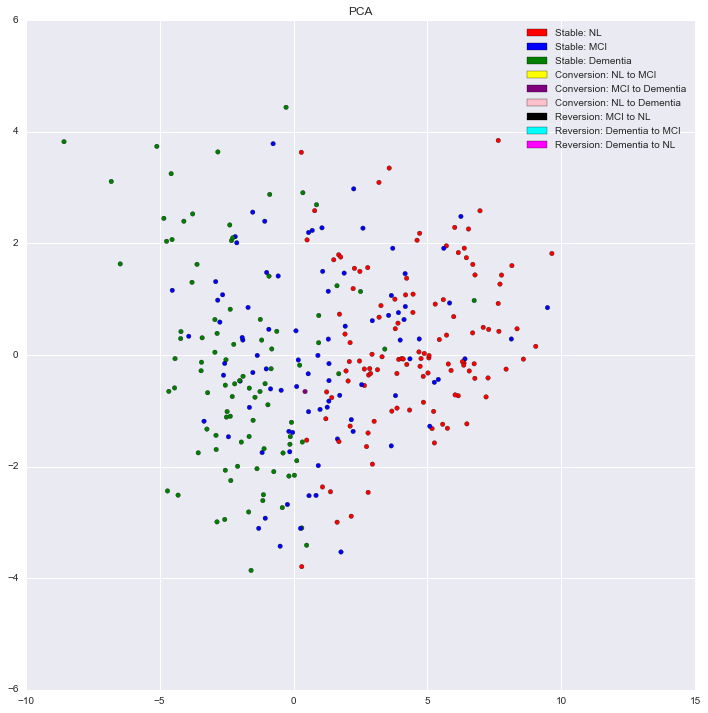

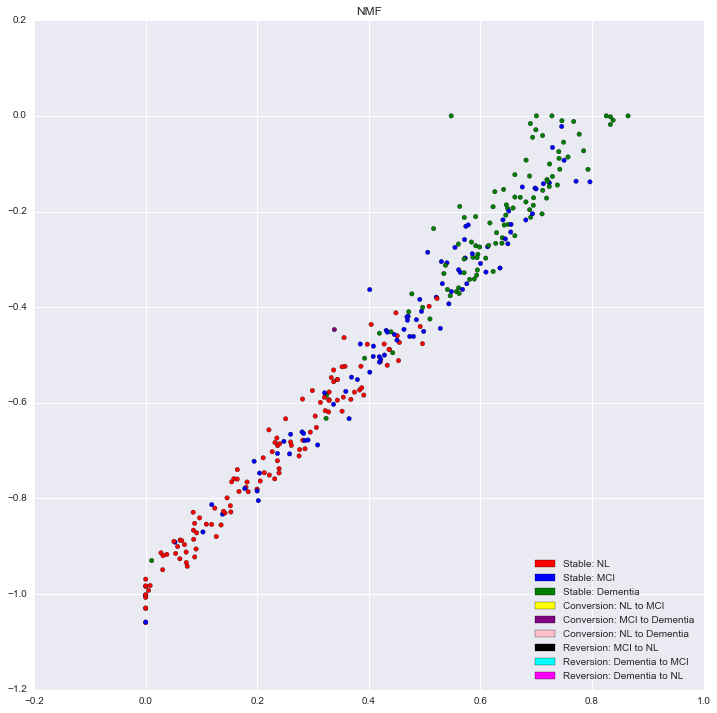

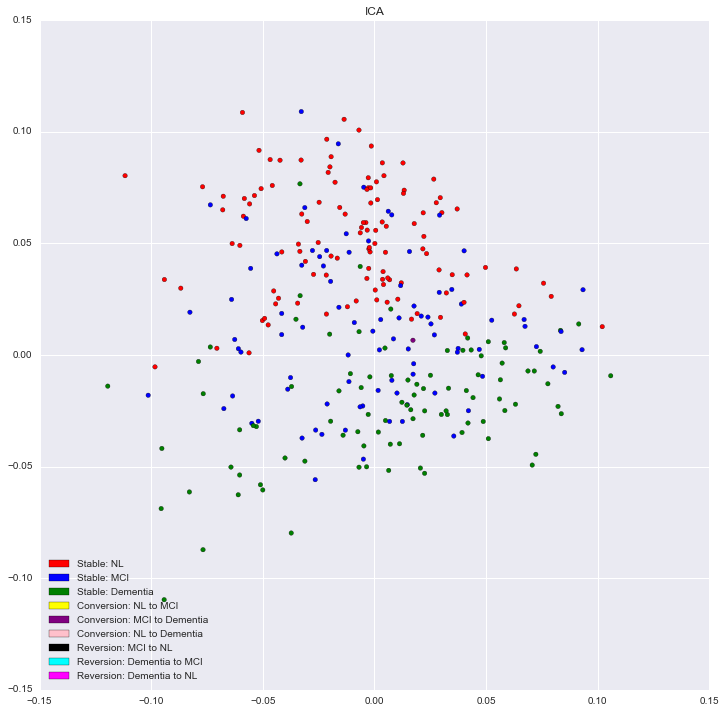

In [50]:
projections(redued_item_36,colors_categories_item_36)

#### Case 1 (Moca) with PCA gives best progression.
#### Even with case 2 (Item) PCA gives best progression

### Following Graph Visualizes distribution of data

In [52]:
#VISUALISATIONS 
cols['adni_merge'] = ['RID', 'VISCODE','COLPROT','AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY']
adni_merge = pd.read_csv('ADNI\\Raw_Data\\Demographic_Plots\\ADNIMERGE.csv', usecols=cols['adni_merge'], index_col = ['RID'])

#The patient who visited again and again in different VISCODES, keeping only the first visit
adni_merge = adni_merge.groupby(adni_merge.index).min()


### PLOTS

In [53]:
#Demographic Plots 
def plots(data):
    dataset = eval(data)
    '''
    #Plotting the VISCODE Distribution of all the patients 
    plt.figure(figsize = (15,10))
    sns.countplot(x='VISCODE', data=adni_merge, palette="Greens_d");
    plt.show()
    plt.savefig('ADNI/Raw_Data/Demographic_Plots/VISCODE_'+str(data)+'.jpg')
    '''
              
    #Plotting the COLPROT (Data Collection Protocol ) for all the patients  (Phase) 
    plt.figure(figsize = (8, 8))
    sns.countplot(x='COLPROT', data=dataset, palette="Greens_d");
    plt.xlabel('Data Collection Protocol')
    plt.title('Data Collection Protocol')
    plt.savefig('ADNI/Raw_Data/Demographic_Plots/COLPROT_'+str(data)+'.jpg')
    plt.show()
    
    #Plotting the AGE Distribution of all the patients 
    plt.figure(figsize = (8, 8))
    sns.distplot(dataset['AGE'], bins=20, kde=False, rug=True);
    plt.xlabel('Age')
    plt.title('Age')
    plt.savefig('ADNI/Raw_Data/Demographic_Plots/AGE_'+str(data)+'.jpg')
    plt.show()
    
    #Plotting the Gender Distribution of all the patients 
    plt.figure(figsize = (8, 8))
    sns.countplot(x='PTGENDER', data=dataset, palette="Greens_d");
    plt.xlabel('Gender')
    plt.title('Gender')
    plt.savefig('ADNI/Raw_Data/Demographic_Plots/GENDER_'+str(data)+'.jpg')
    plt.show()
    
    
    #Plotting the Education distribution of all the patients
    plt.figure(figsize = (8, 8))
    sns.countplot(x='PTEDUCAT', data=dataset, palette="Greens_d");
    plt.xlabel('Education')
    plt.title('Education')
    plt.savefig('ADNI/Raw_Data/Demographic_Plots/EDUCATION_'+str(data)+'.jpg')
    plt.show()
    
    #Plotting Ethinicity of all the patients
    plt.figure(figsize = (8, 8))
    sns.countplot(x='PTETHCAT', data=dataset, palette="Greens_d");
    plt.xlabel('Ethnicity')
    plt.title('Ethnicity')
    plt.savefig('ADNI/Raw_Data/Demographic_Plots/Ethnicity_'+str(data)+'.jpg')
    plt.show()
    
    #Plotting Race of all the patients
    plt.figure(figsize = (15, 10))
    sns.countplot(x='PTRACCAT', data=dataset, palette="Greens_d");
    plt.xlabel('Race')
    plt.title('Race')
    plt.savefig('ADNI/Raw_Data/Demographic_Plots/RACE_'+str(data)+'.jpg')
    plt.show()
    
    #Plotting Marital Status of all the patients 
    plt.figure(figsize = (8, 8))
    sns.countplot(x='PTMARRY', data=dataset, palette="Greens_d");
    plt.xlabel('Marital Status')
    plt.title('Marital Status')
    plt.savefig('ADNI/Raw_Data/Demographic_Plots/'+'MARRY_'+str(data)+'.jpg')
    plt.show()

### FOR ALL THE PATIENTS

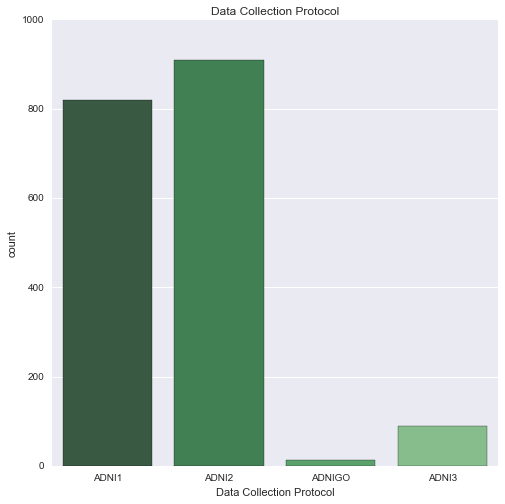

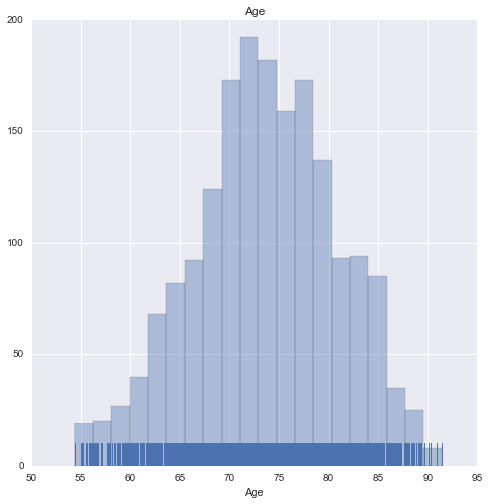

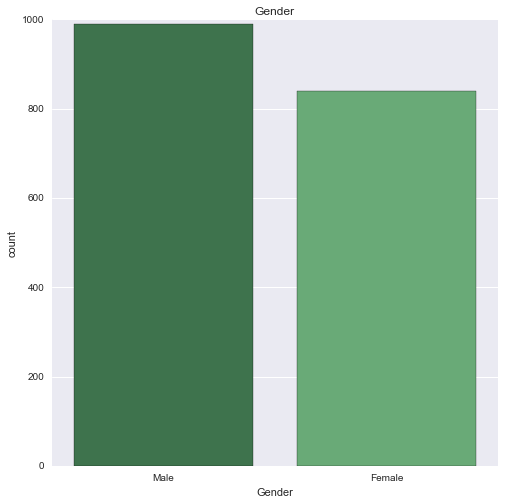

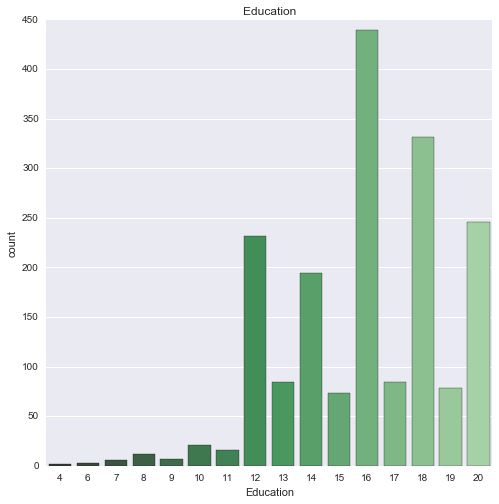

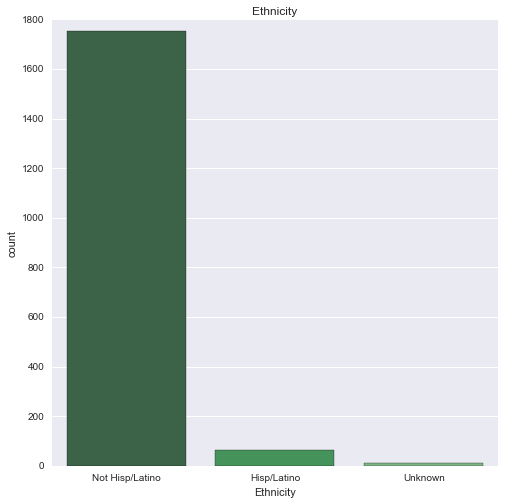

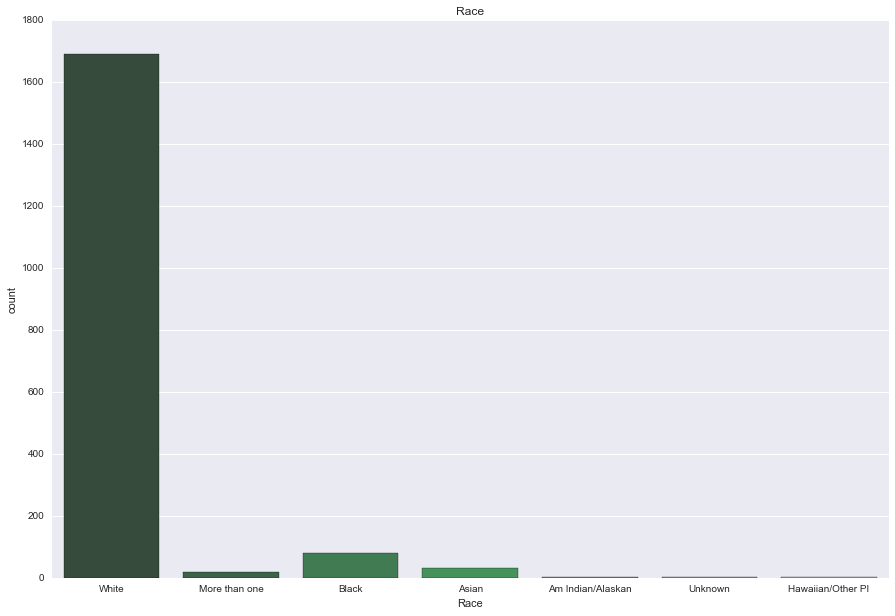

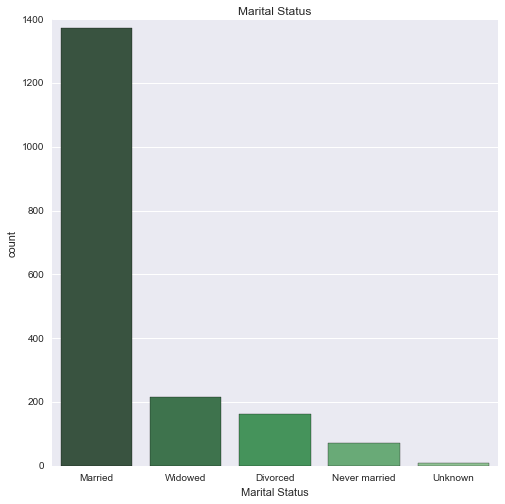

In [54]:
#All Demographic info of all patients 
plots('adni_merge')

### Filtering ADNI_MERGE wrt COLPROT (Phase)

In [55]:
adni_merge_ADNI1 = adni_merge[adni_merge['COLPROT']=='ADNI1']
adni_merge_ADNI2 = adni_merge[adni_merge['COLPROT']=='ADNI2']
adni_merge_ADNI3 = adni_merge[adni_merge['COLPROT']=='ADNI3']
adni_merge_ADNIGO = adni_merge[adni_merge['COLPROT']=='ADNIGO']

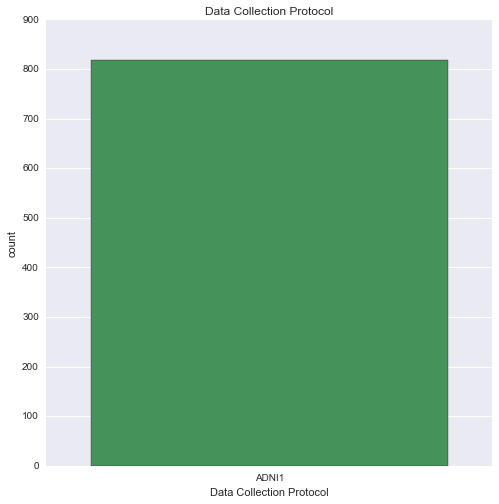

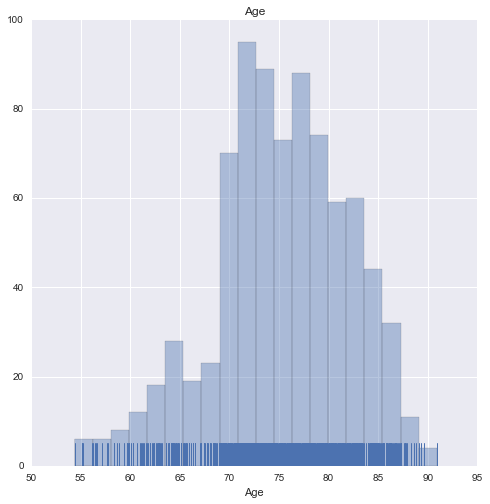

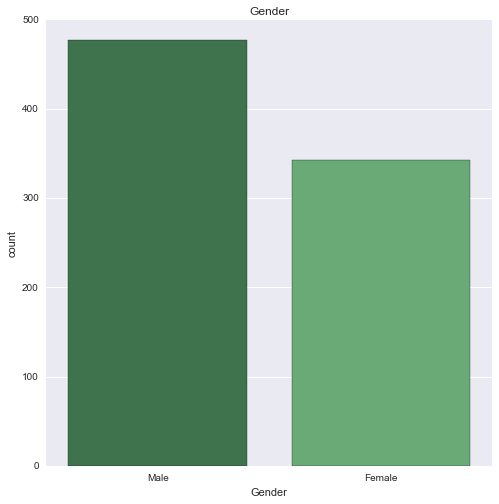

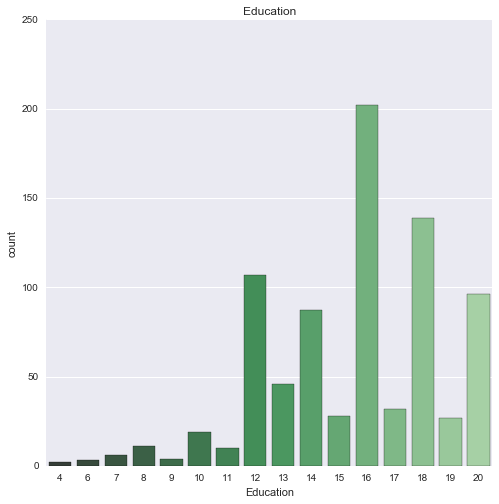

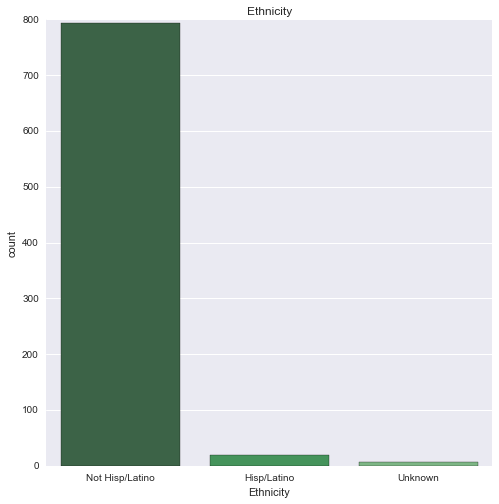

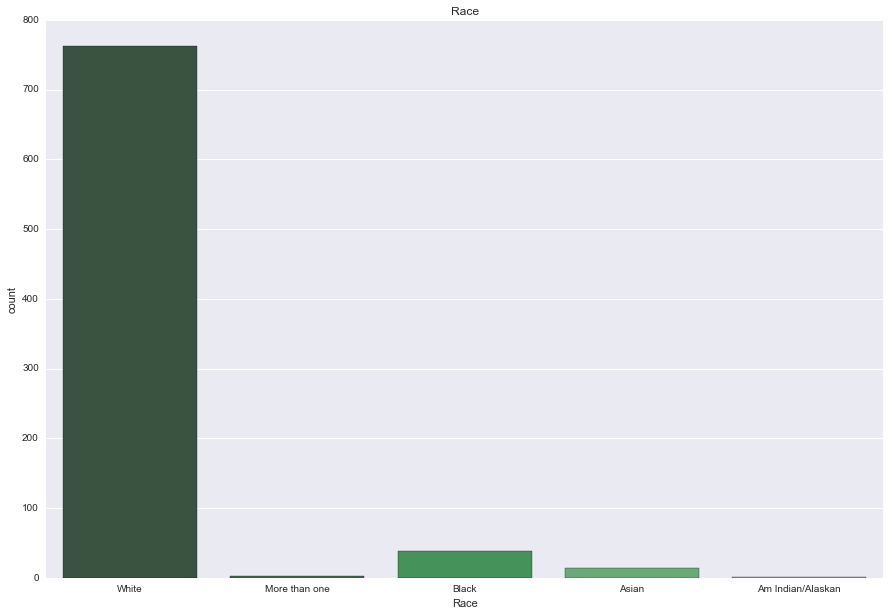

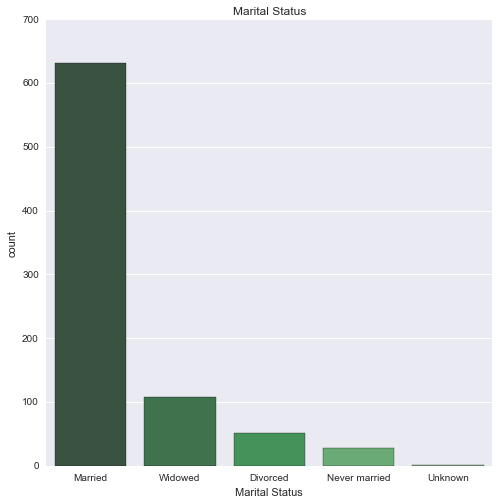

In [56]:
#All the patients with ADNI1 Phase
plots('adni_merge_ADNI1') #Plotting Demographies only for ADNI1

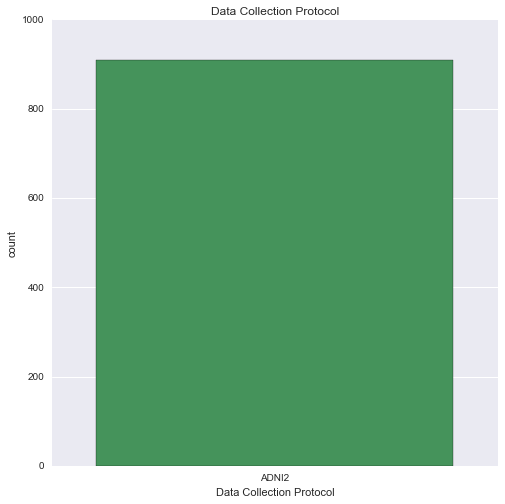

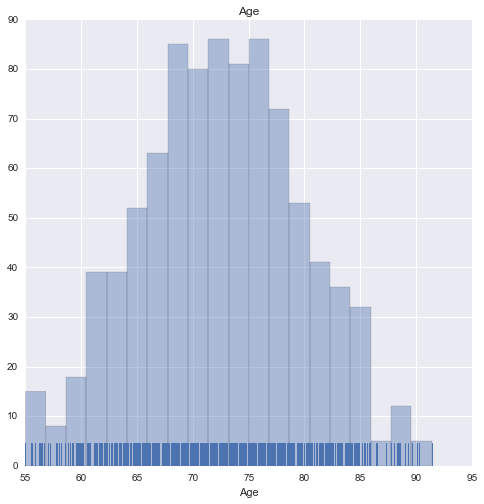

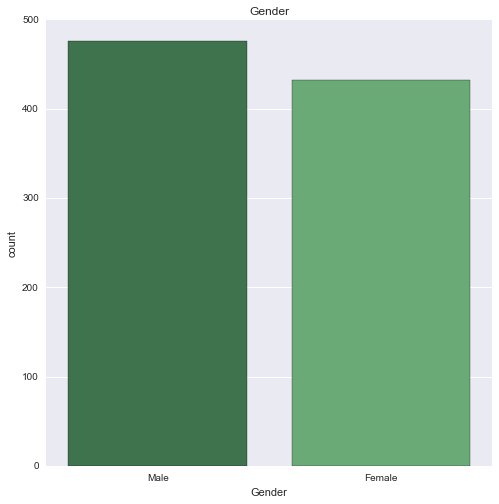

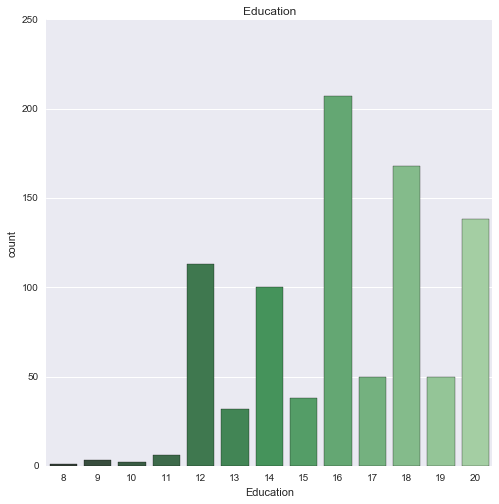

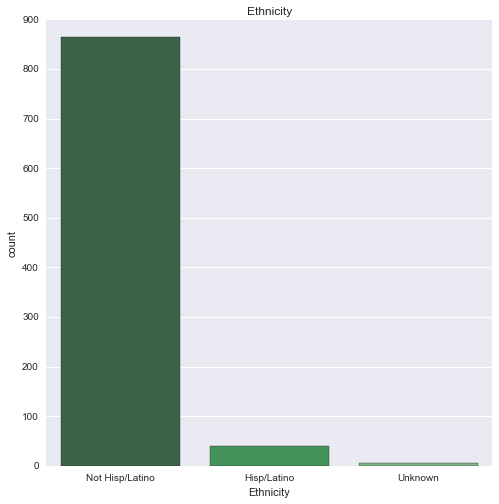

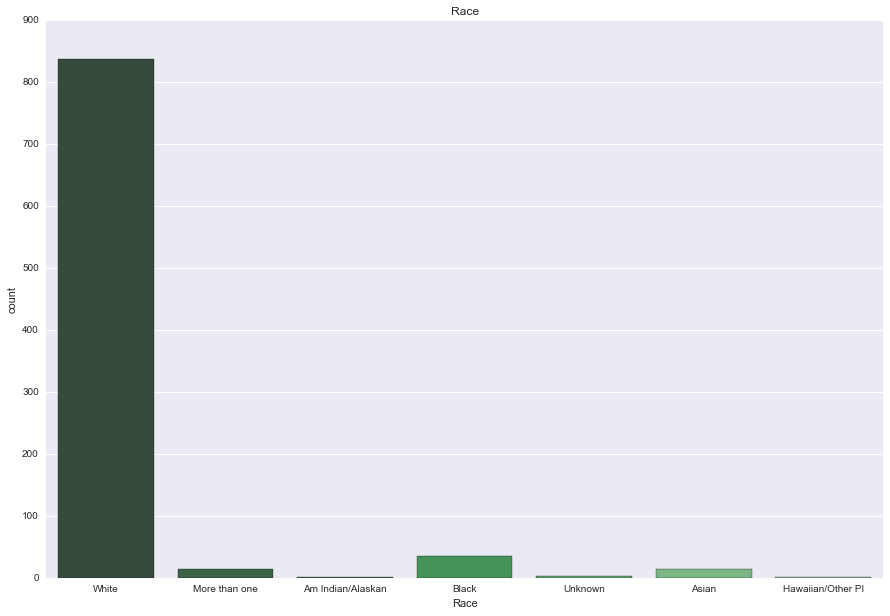

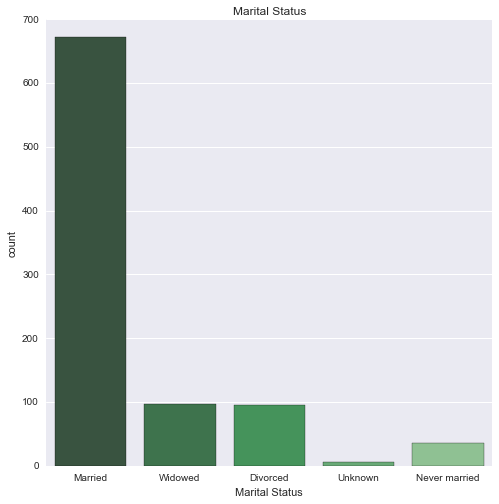

In [57]:
#All the patients with ADNI2 Phase
plots('adni_merge_ADNI2') #Plotting Demographies only for ADNI2

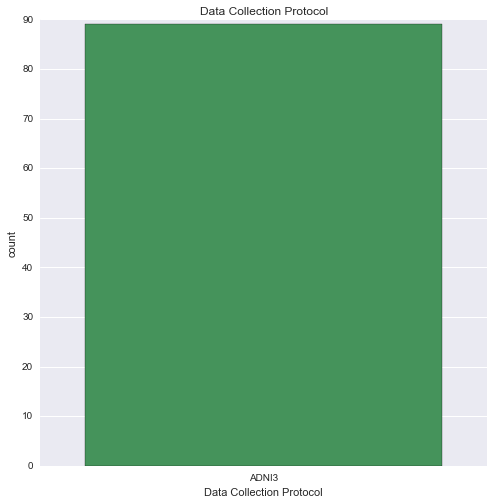

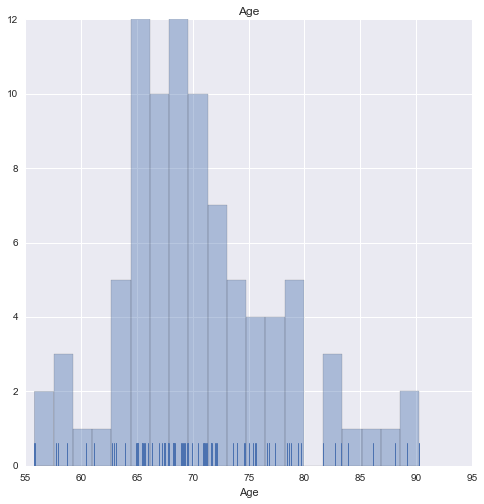

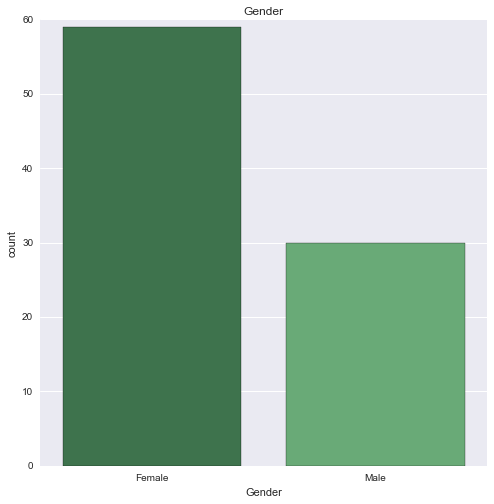

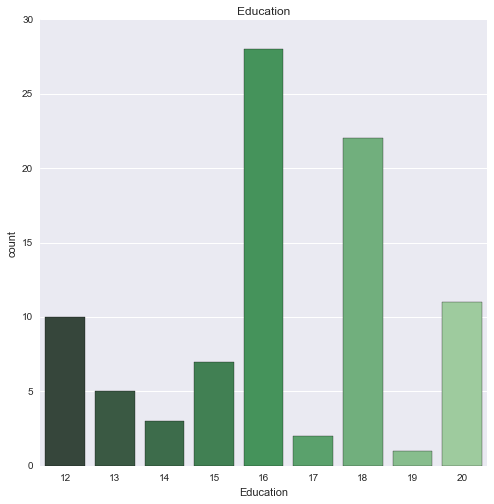

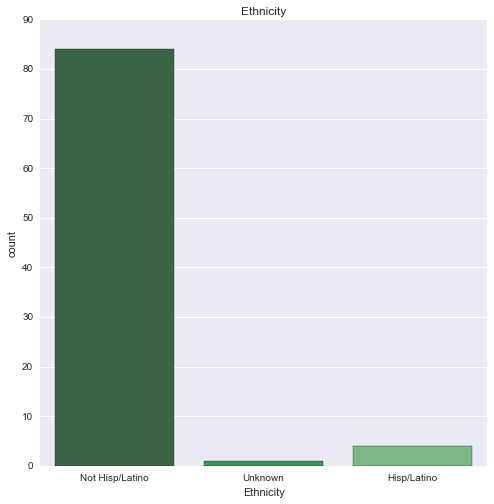

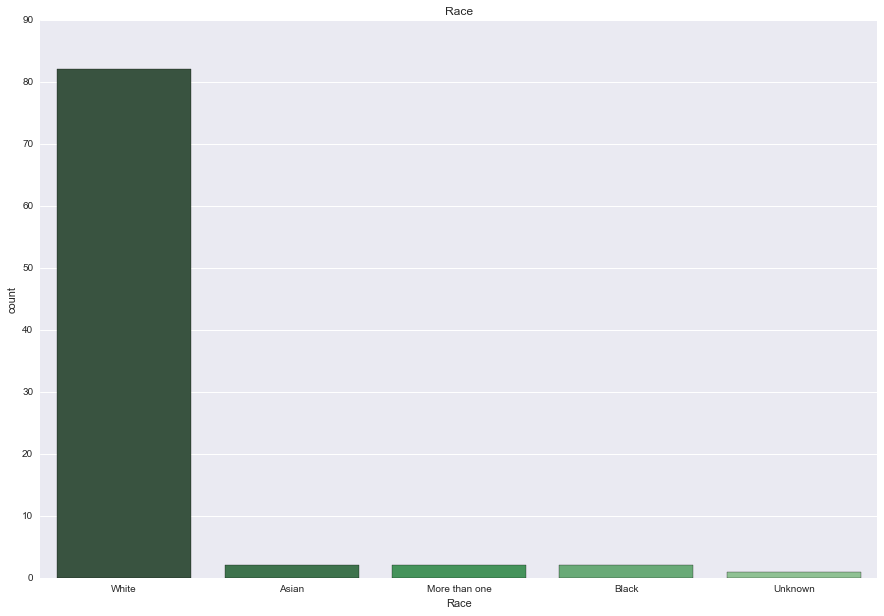

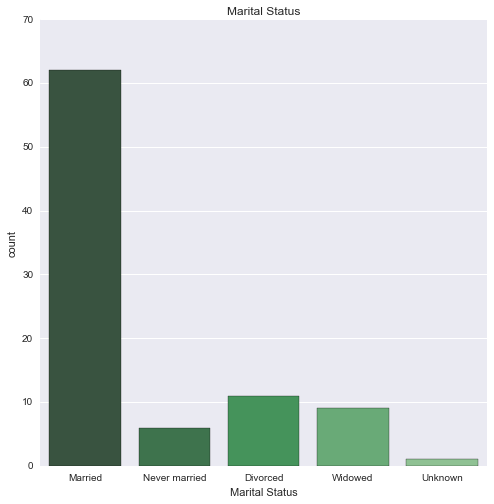

In [58]:
#All the patients with ADNI3 Phase
plots('adni_merge_ADNI3') #Plotting Demographies only for ADNI3

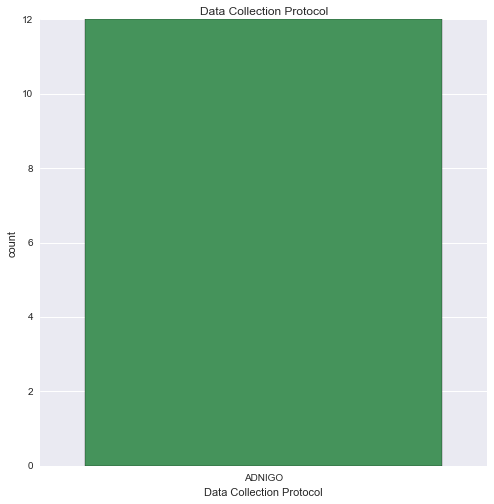

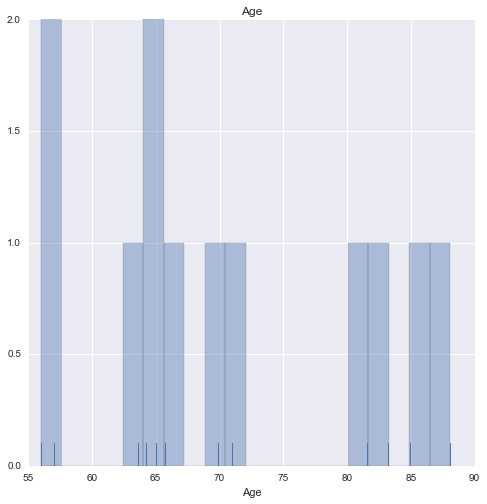

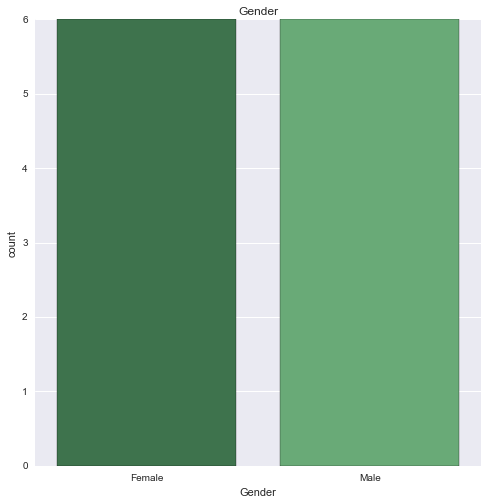

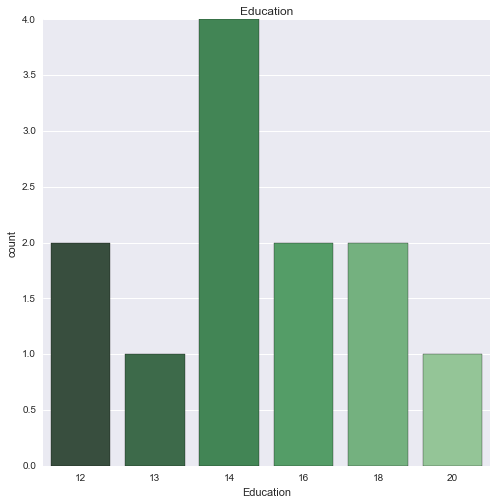

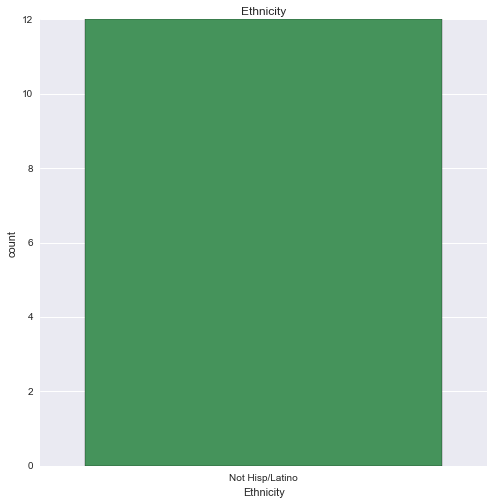

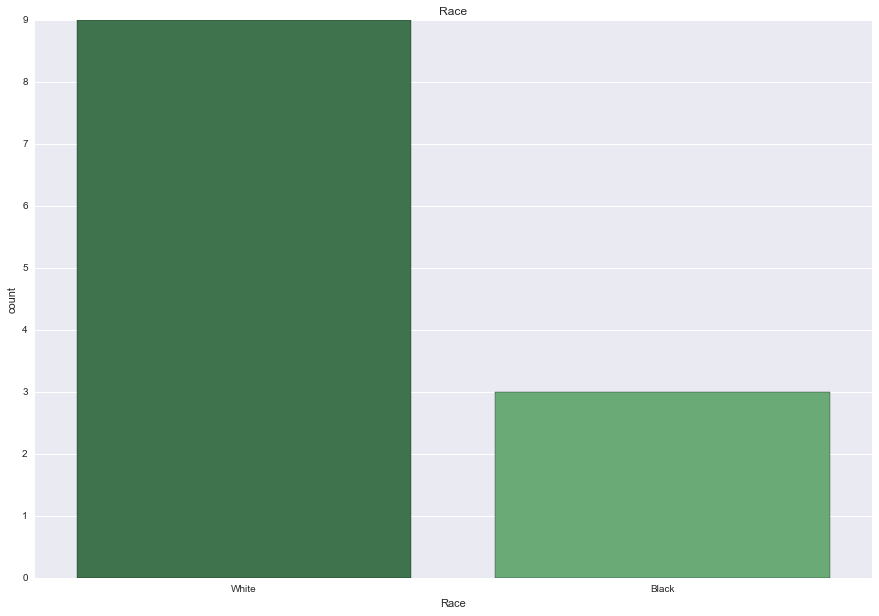

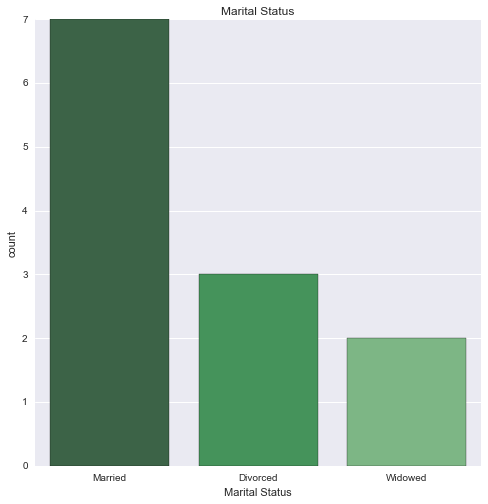

In [59]:
#All the patients with ADNIGO Phase
plots('adni_merge_ADNIGO') #Plotting Demographies only for ADNIGO

In [60]:
#Plotting the labels information for all the patients - REPEATED RIDS'
diagnosis1 = pd.read_csv("ADNI\\Raw_Data\\Assessment\\DXSUM_PDXCONV_ADNIALL.csv",  usecols= ['RID','DXCHANGE','DXCURREN', 'DIAGNOSIS', 'VISCODE2'])
diagnosis1['Label_all'] = diagnosis1[['DXCHANGE', 'DXCURREN', 'DIAGNOSIS']].sum(skipna = True, numeric_only = True, axis = 1)
#Keeping only Labelled Non NULL values 
diagnosis1_label = diagnosis1[~diagnosis1['Label_all'].isnull()]
diagnosis1_label = diagnosis1_label.set_index('RID')

In [61]:
#These labels only exist for all ADNI
def label_plots(data, visit_code):
    dataset = eval(data)
    dataset= dataset[dataset['VISCODE2']==visit_code] #Plotting only for a particular visit code
    plt.figure(figsize = (20,6))
    sns.countplot(x = 'Label_all', data=dataset, palette="Greens_d");
    plt.xlabel('Labels ')
    plt.title('Labels ')
    plt.xticks(range(9), ('Stable: NL', 'Stable: MCI', 'Stable: Dementia', 'Conversion: NL to MCI', 'Conversion: MCI to Dementia', 'Conversion: NL to Dementia', 'Reversion: MCI to NL','Reversion: Dementia to MCI','Reversion: Dementia to NL'))
    plt.savefig('ADNI/Raw_Data/Demographic_Plots/Labels_'+str(data)+'_'+str(visit_code)+'.jpg')
    plt.show()

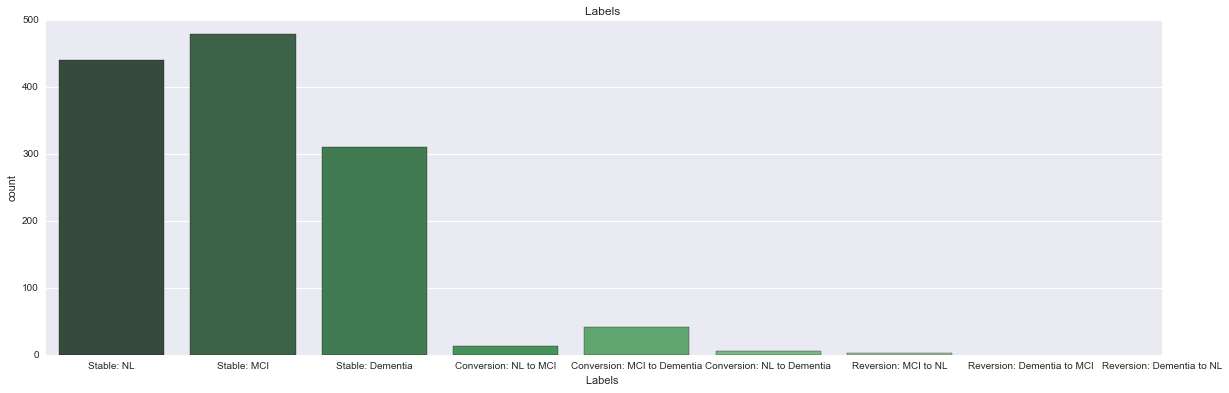

In [62]:
#All the patients with m24 visit
label_plots('diagnosis1_label', 'm24')

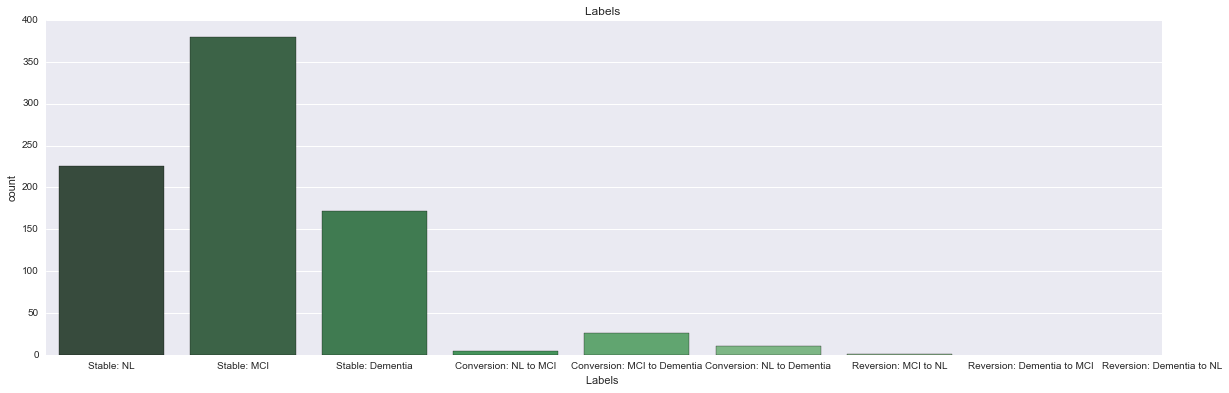

In [63]:
#All the patients with m36 visit
label_plots('diagnosis1_label', 'm36')

### SELECTED PATIENTS

#### Dataset 'redued_moca_36' may be replaced with redued_moca_24, redued_item_36, redued_item_24

In [64]:
#Without true label discritization 
#Demographic Plots
adni_merge_chosen = adni_merge[adni_merge.index.isin(redued_moca_36.index)] #CHANGE HERE FOR DIFFERENT DATASETS 

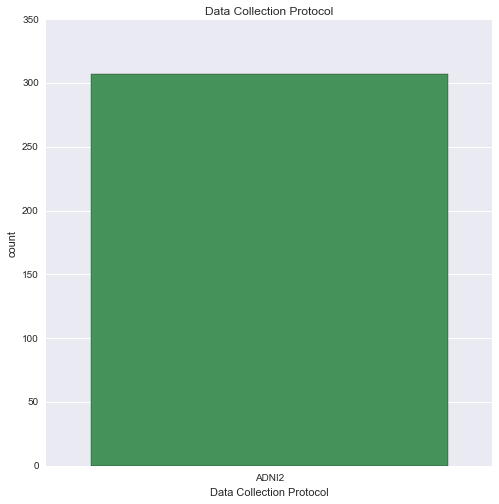

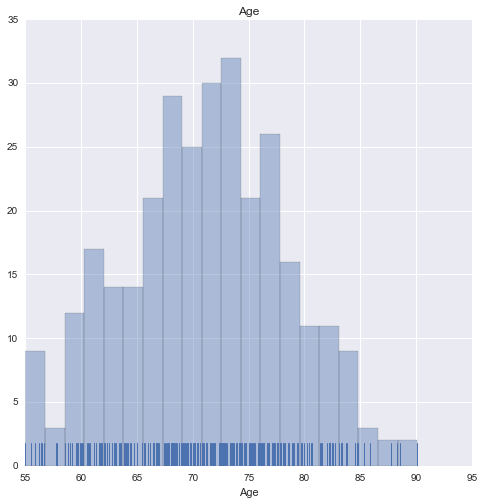

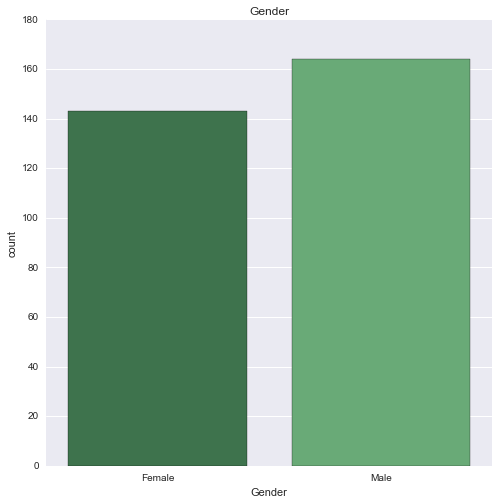

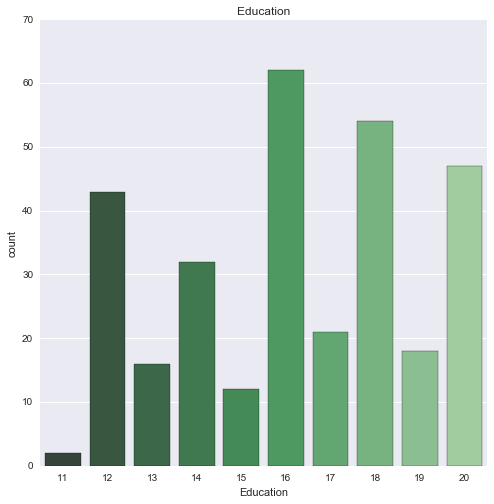

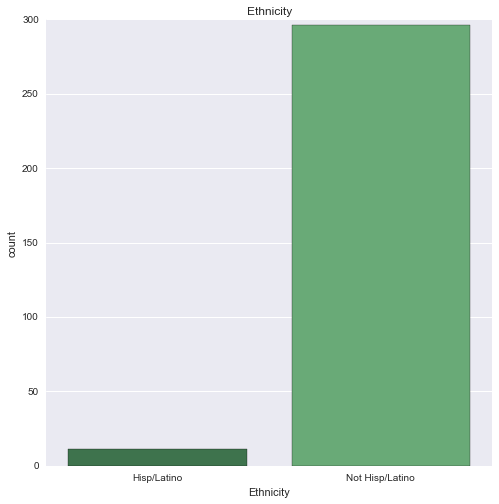

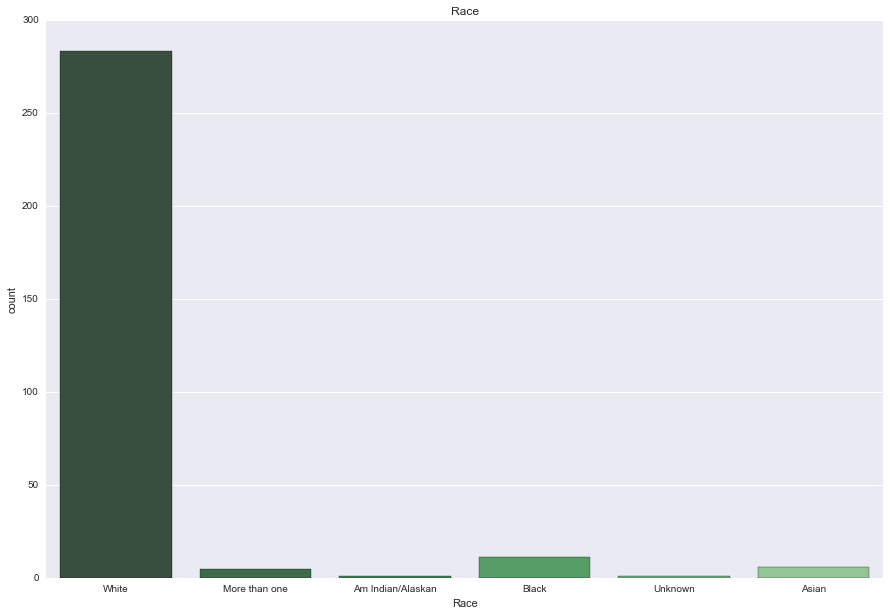

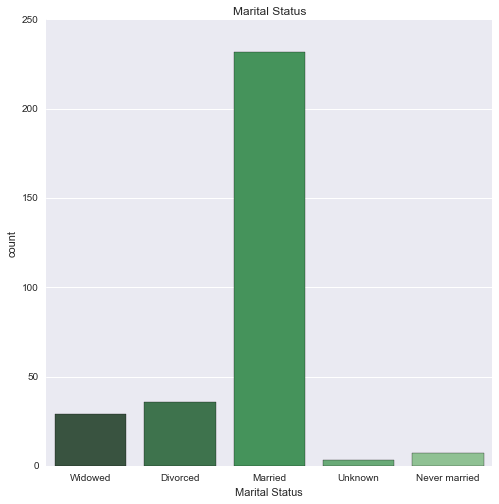

In [65]:
#Only for all selected cohort, the visualizations of demographic information 
plots('adni_merge_chosen')

### Plotting the labels information 

#### Dataset 'redued_moca_36' may be replaced with redued_moca_24, redued_item_36, redued_item_24

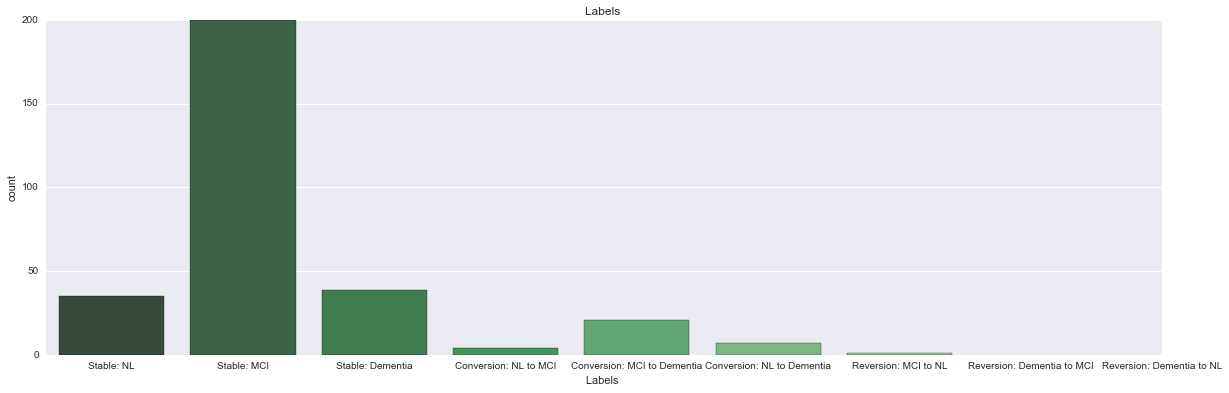

In [66]:
diagnosis1_chosen = diagnosis1_label[diagnosis1_label.index.isin(redued_moca_36.index)]
label_plots('diagnosis1_chosen', 'm36')

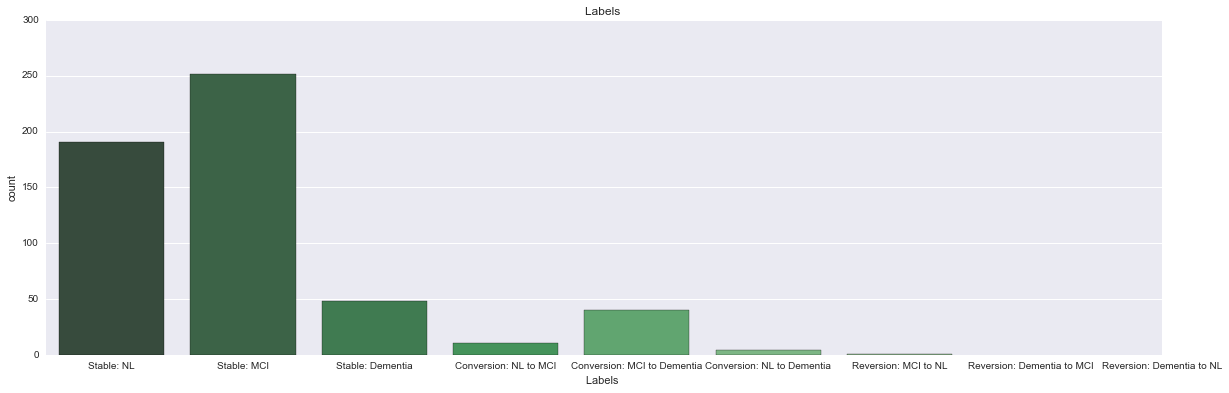

In [67]:
#Labels for m24
diagnosis1_chosen = diagnosis1_label[diagnosis1_label.index.isin(redued_moca_24.index)]
label_plots('diagnosis1_chosen', 'm24')

In [68]:
#With true label discritization 
adni_merge_chosen_labelled = adni_merge_chosen.merge(diagnosis1_label, how = 'inner', left_index = True, right_index = True)
#Has Repeated Entries - Choose m24

In [69]:
def plot_chosen_labels(category, visit_code):
    adni_merge_chosen_labelled1 = adni_merge_chosen_labelled[adni_merge_chosen_labelled['VISCODE2']==visit_code]
    NL = adni_merge_chosen_labelled1[adni_merge_chosen_labelled1['Label_all'] ==1]
    MCI = adni_merge_chosen_labelled1[adni_merge_chosen_labelled1['Label_all'] ==2]
    Dim = adni_merge_chosen_labelled1[adni_merge_chosen_labelled1['Label_all'] ==3]
    NL_MCI = adni_merge_chosen_labelled1[adni_merge_chosen_labelled1['Label_all'] ==4]
    MCI_Dim = adni_merge_chosen_labelled1[adni_merge_chosen_labelled1['Label_all'] ==5]
    NL_Dim = adni_merge_chosen_labelled1[adni_merge_chosen_labelled1['Label_all'] ==6]
    MCI_NL = adni_merge_chosen_labelled1[adni_merge_chosen_labelled1['Label_all'] ==7]
    Dim_MCI = adni_merge_chosen_labelled1[adni_merge_chosen_labelled1['Label_all'] ==8]
    Dim_NL = adni_merge_chosen_labelled1[adni_merge_chosen_labelled1['Label_all'] ==9]
    plt.figure(figsize=(15,6))
    concat = pd.concat([NL[category], MCI[category], Dim[category], NL_MCI[category], MCI_Dim[category], NL_Dim[category], MCI_NL[category], Dim_MCI[category], Dim_NL[category]  ], axis=1)
    concat.plot(kind='hist', title="Histogram of "+str(category), alpha=0.7, bins=15, ax=plt.gca())
    plt.xlabel(category)
    plt.legend(['Stable: NL', 'Stable: MCI', 'Stable: Dementia', 'Conversion: NL to MCI', 'Conversion: MCI to Dementia', 'Conversion: NL to Dementia', 'Reversion: MCI to NL','Reversion: Dementia to MCI','Reversion: Dementia to NL'])
    plt.savefig('ADNI/Raw_Data/Chosen_Labelled/'+str(category) + '_'+str(visit_code)+'.jpg')
    plt.show()


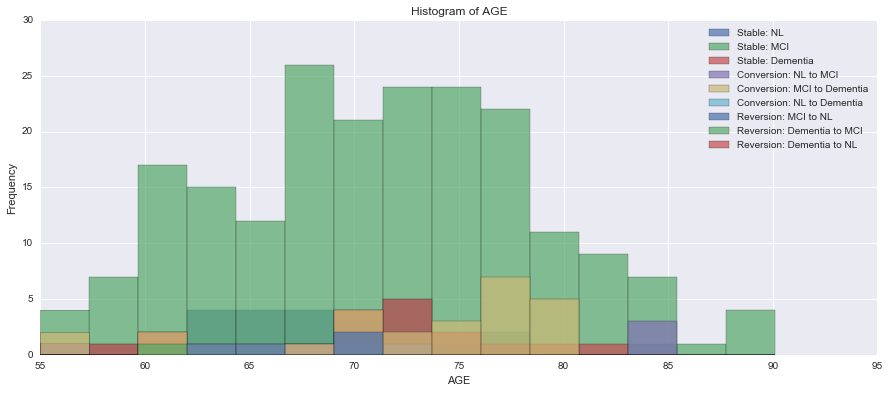

In [71]:
#Age with labels 
plot_chosen_labels('AGE', 'm24')

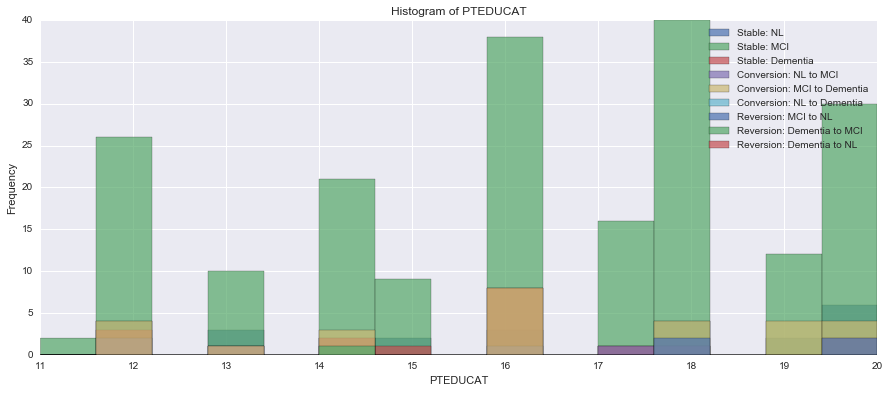

In [72]:
#Education with labels 
plot_chosen_labels('PTEDUCAT', 'm24')

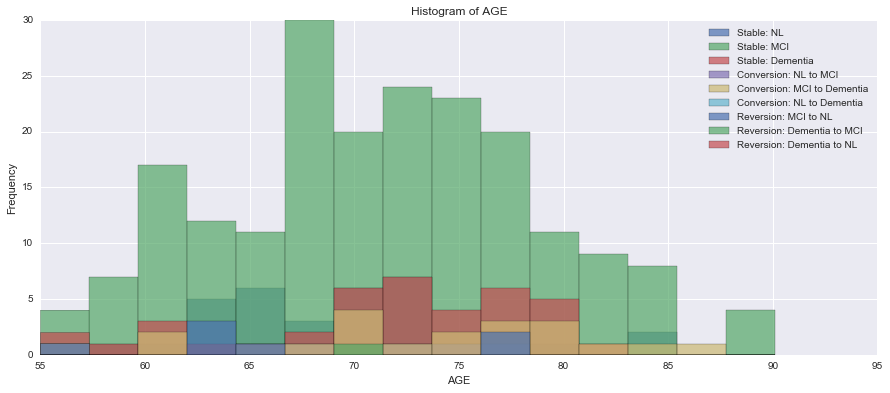

In [73]:
plot_chosen_labels('AGE', 'm36')

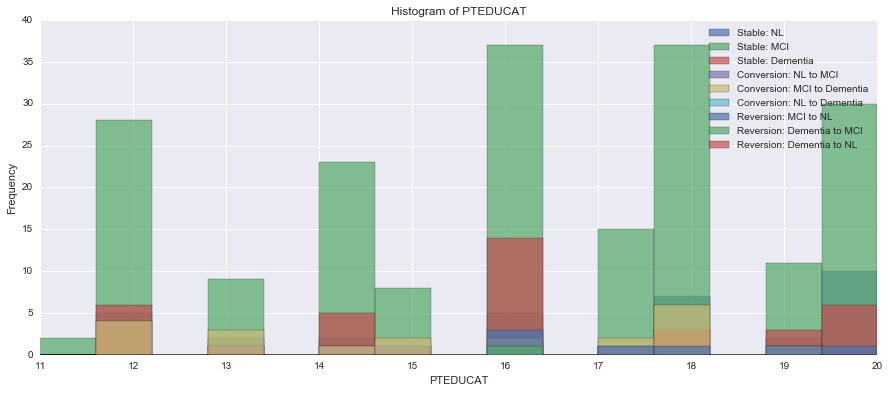

In [74]:
plot_chosen_labels('PTEDUCAT', 'm36')

In [75]:
def plot_chosen_labels2(category, visit_code):
    adni_merge_chosen_labelled1 = adni_merge_chosen_labelled[adni_merge_chosen_labelled['VISCODE2']==visit_code]
    plt.figure(figsize=(8,6))
    sns.countplot(x = category, hue = 'Label_all', data = adni_merge_chosen_labelled1)
    plt.xlabel(category)
    plt.legend(['Stable: NL', 'Stable: MCI', 'Stable: Dementia', 'Conversion: NL to MCI', 'Conversion: MCI to Dementia', 'Conversion: NL to Dementia', 'Reversion: MCI to NL','Reversion: Dementia to MCI','Reversion: Dementia to NL'])
    plt.savefig('ADNI/Raw_Data/Chosen_Labelled/'+str(category) + '_'+str(visit_code)+'.jpg')
    plt.show()

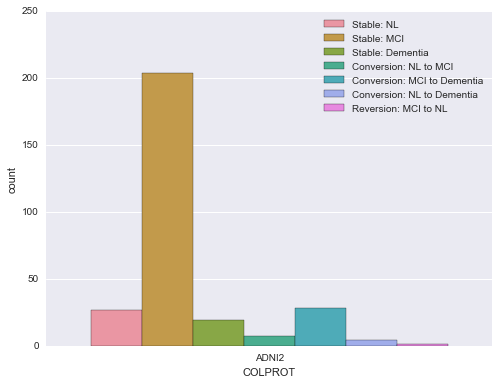

In [76]:
#For m24, Phase
plot_chosen_labels2('COLPROT', 'm24')

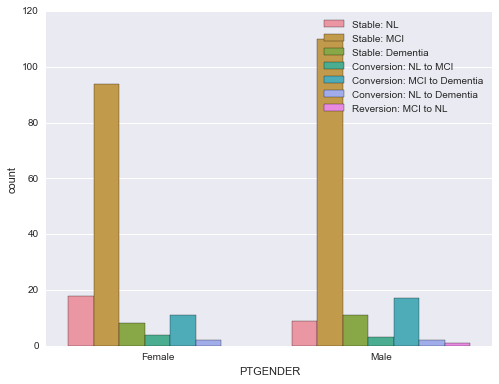

In [77]:
#Gender
plot_chosen_labels2('PTGENDER', 'm24')

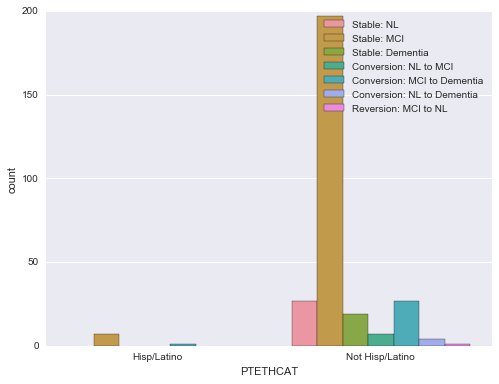

In [78]:
#Ethnicity
plot_chosen_labels2('PTETHCAT', 'm24')

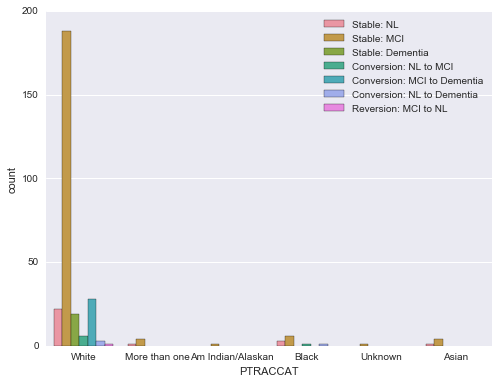

In [79]:
#Race Category
plot_chosen_labels2('PTRACCAT', 'm24')

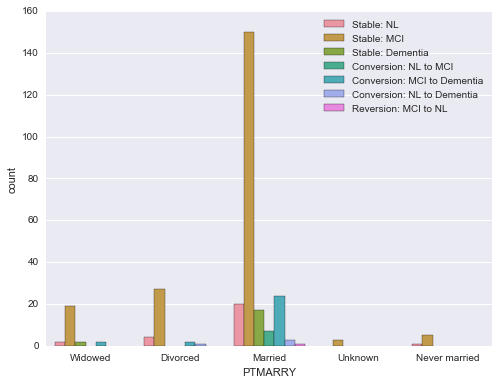

In [80]:
#Marital Status
plot_chosen_labels2('PTMARRY', 'm24')

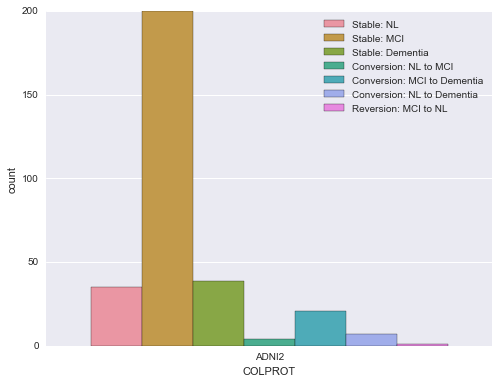

In [81]:
#For m36, Phase
plot_chosen_labels2('COLPROT', 'm36')

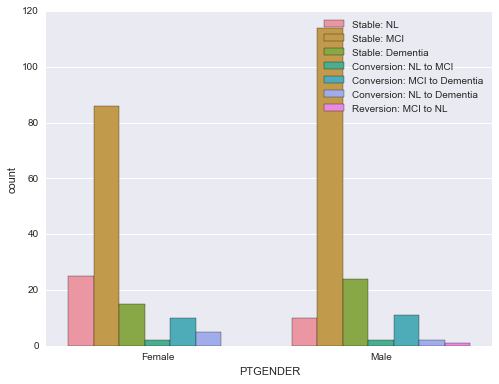

In [82]:
#Gender
plot_chosen_labels2('PTGENDER', 'm36')

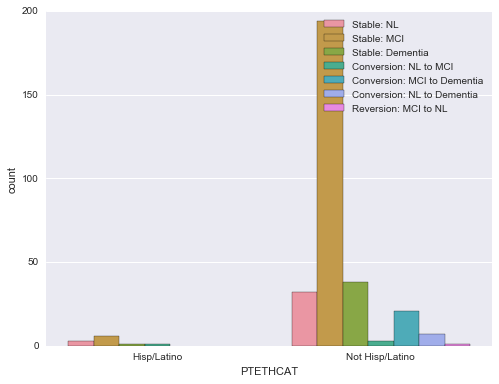

In [83]:
#Ethnicity
plot_chosen_labels2('PTETHCAT', 'm36')

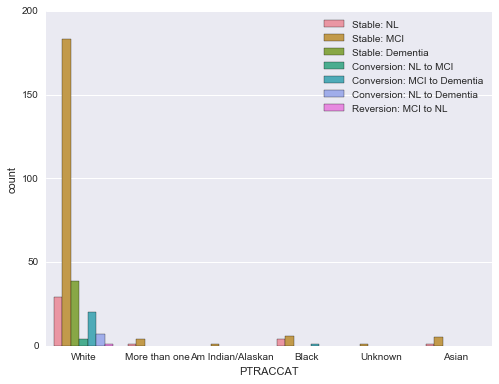

In [84]:
#Race Category
plot_chosen_labels2('PTRACCAT', 'm36')

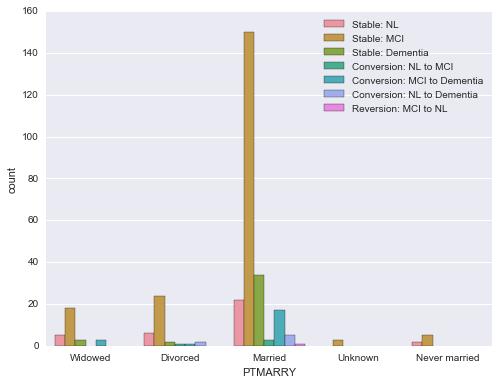

In [85]:
#Marital Status
plot_chosen_labels2('PTMARRY', 'm36')